# Relating Tracked Particles to Ram Pressure & Tidal Stripping

The code in this notebook ties together the tracked particles data (`../../Data/tracked_particles.hdf5`) with the ram pressure data (`../../Data/ram_pressure.hdf5`). 

## Table of Contents
- [Rates vs. Distance](#rates-distance)
- [Second Bullet Header](#second-bullet)
- [Sanity check: Predicting Gas Mass](#sanity)
- Expulsion Rate vs. Ram Pressure
- Expulsion Probability
- Tidal Effects
- Decomposing Restoring Pressure
- Gas Depletion Times




In [1]:
# import my custom module which includes my analysis functions (also imports everything from base.py)
from analysis import * 

# Schematic Figure

(Note: no longer quite accurate)

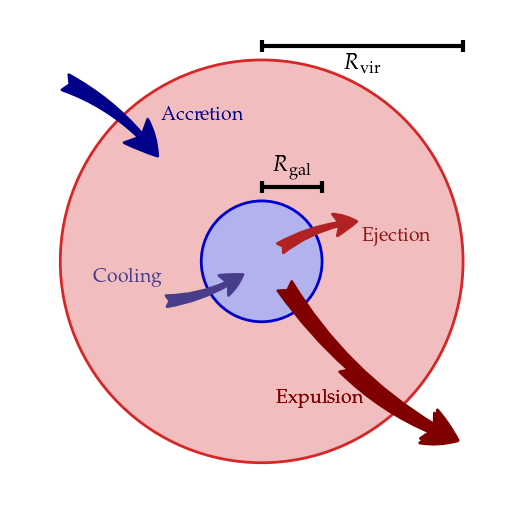

In [119]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))

circ = mpl.patches.Circle((0,0),radius=10, fc='tab:red', ec='none', alpha=0.3)
ax.add_patch(circ)

circ = mpl.patches.Circle((0,0),radius=10, fc='none', ec='tab:red')
ax.add_patch(circ)

circ = mpl.patches.Circle((0,0), radius=3, fc='w', ec='none')
ax.add_patch(circ)

circ = mpl.patches.Circle((0,0), radius=3, fc='mediumblue', ec='none', alpha=0.3)
ax.add_patch(circ)

circ = mpl.patches.Circle((0,0), radius=3, fc='none', ec='mediumblue')
ax.add_patch(circ)

ax.set_aspect('equal')

style = "fancy, tail_width=0.2"
kw = dict(arrowstyle=style, mutation_scale=30)
a1 = mpl.patches.FancyArrowPatch((-10, 9), (-5, 5), connectionstyle="arc3,rad=-0.14", **kw, color='darkblue')
ax.add_patch(a1)
ax.annotate('Accretion', (-5, 7), fontsize=7, color='darkblue')

a2 = mpl.patches.FancyArrowPatch((4, -5), (10, -9), connectionstyle="arc3,rad=0.14", **kw, color='maroon')
ax.add_patch(a2)
ax.annotate('Expulsion', (5, -7), fontsize=7, ha='right', color='maroon')

a21 = mpl.patches.FancyArrowPatch((1, -1), (10, -9), connectionstyle="arc3,rad=0.14", **kw, color='maroon')
ax.add_patch(a21)


kw = dict(arrowstyle=style, mutation_scale=20)
a3 = mpl.patches.FancyArrowPatch((0.7,0.5), (5, 2), connectionstyle="arc3,rad=-0.14", **kw, color='firebrick')
ax.add_patch(a3)
ax.annotate('Ejection', (5, 1), fontsize=7, ha='left', color='firebrick')
ax.annotate('Ejection', (5, 1), fontsize=7, ha='left', color='k', alpha=0.2)

a4 = mpl.patches.FancyArrowPatch((-5, -2), (-0.7,-0.5), connectionstyle="arc3,rad=0.14", **kw, color='darkslateblue')
ax.add_patch(a4)
ax.annotate('Cooling', (-5, -1), fontsize=7, ha='right', color='darkslateblue')

plt.errorbar([1.5],[3.7], xerr=1.5, elinewidth=1.5, capsize=2, capthick=1.5, ms=0, color='k')
plt.errorbar([5],[10.7], xerr=5, elinewidth=1.5, capsize=2, capthick=1.5, ms=0, color='k')
ax.annotate(r'$R_{\rm vir}$', (5, 9.5), ha='center', fontsize=8)
ax.annotate(r'$R_{\rm gal}$', (1.5, 4.5), ha='center', fontsize=8)
ax.set_xlim(-12,12)
ax.set_ylim(-12,12)

ax.axis('off')

plt.savefig('plots/flow_schematic.pdf')
plt.show()

## Overview of ram pressure data

In [624]:
path = '../../Data/ram_pressure.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])
print('Available keys:', *keys)

Available keys: h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33


In [625]:
key = 'h242_24'
data = pd.read_hdf(path, key=key)

In [626]:
data.head()

t         a      h1dist         dNN              M_star  \
0  5.181190  0.457383  270.700020  214.411852  10926199.689136274   
0  5.504425  0.477562  243.388818  224.668845   11394804.86943274   
0  5.827660  0.497567  218.796210  218.796210  11742831.402330164   
0  5.868065  0.500057  217.276565  217.276565   11739667.73945315   
0  6.150896  0.517431  214.708289  214.708289  11804031.617436804   

                M_gas    satRvir    hostRvir     vel_CGM     rho_CGM  ...  \
0  208360240.15028733  25.369893  130.372500  146.116291  297.532593  ...   
0  200475313.63009107  26.397561  139.584329  152.728547  335.757067  ...   
0  178252830.60788983  27.510683  149.873385  156.932052  417.353072  ...   
0  167131414.92211688  27.655739  151.117806  157.010812  419.860050  ...   
0  158417341.00968948  28.677711  158.704713  158.722577  404.527711  ...   

   vel_CGM_adv        rho_CGM_adv  std_vel_CGM         std_rho_CGM  \
0    21.935931  661.1679453030997     7.723319  302.45599622859504   
0    57.279242  925.3381030381855    23.620708   556.6821008504479   
0    63.191170  749.4751231578379    22.172040  202.14561845966986   
0    59.070037  673.3153673520156    22.927114  160.53879150601446   
0    84.608044  704.9558276934247    22.474083  104.03481429301992   

             Pram_adv               Prest           SigmaGas      dphidz  \
0  318144.13002917415   590614619.2511803  930568.1140627366  634.681772   
0  3035952.4520017477   241491169.1210828  650653.1313660274  371.151936   
0  2992747.0445639887   264478266.0524065  623087.7879784898  424.463890   
0  2349378.6326645687  323055074.14693266  628275.5429422959  514.193299   
0   5046441.204877365   272052342.2112354  553876.2544020915  491.178923   

        SFR         sSFR  
0  0.002114  1.93481e-10  
0  0.000752  6.60241e-11  
0  0.003947  3.36101e-10  
0  0.004003  3.41001e-10  
0  0.001735  1.46989e-10  

[5 rows x 22 columns]

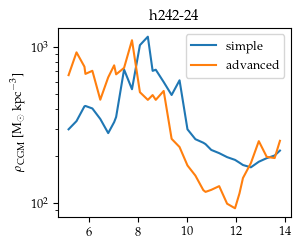

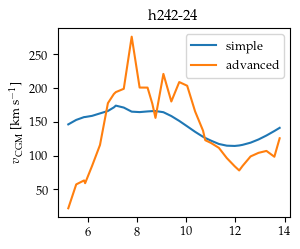

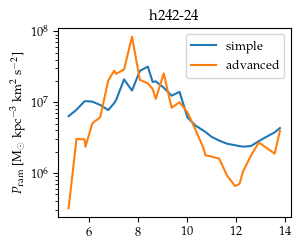

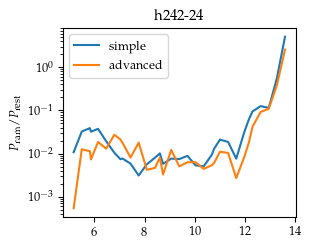

In [627]:
plt.figure(dpi=100, figsize=(3,2.5))
plt.title(key.replace('_','-'))
plt.ylabel(r'$\rho_{\rm CGM}$ [M$_{\odot}~\mathrm{kpc}^{-3}$]')
plt.plot(data.t, data.rho_CGM, label='simple')
plt.plot(data.t, data.rho_CGM_adv, label='advanced')
plt.semilogy()
plt.legend()
plt.show()

plt.figure(dpi=100, figsize=(3,2.5))
plt.title(key.replace('_','-'))
plt.ylabel(r'$v_{\rm CGM}$ [km~s$^{-1}$]')
plt.plot(data.t, data.vel_CGM, label='simple')
plt.plot(data.t, data.vel_CGM_adv, label='advanced')
plt.legend()
plt.show()

plt.figure(dpi=100, figsize=(3,2.5))
plt.title(key.replace('_','-'))
plt.ylabel(r'$P_{\rm ram}$ [M$_{\odot}~\mathrm{kpc}^{-3}~\mathrm{km}^2~\mathrm{s}^{-2}$]')
plt.plot(data.t, data.Pram, label='simple')
plt.plot(data.t, data.Pram_adv, label='advanced')
plt.semilogy()
plt.legend()
plt.show()


plt.figure(dpi=100, figsize=(3,2.5))
plt.title(key.replace('_','-'))
plt.ylabel(r'$P_{\rm ram} / P_{\rm rest}$')
plt.plot(data.t, np.array(data.Pram)/np.array(data.Prest), label='simple')
plt.plot(data.t, np.array(data.Pram_adv)/np.array(data.Prest), label='advanced')
plt.semilogy()
plt.legend()
plt.show()

## Import the data

Here, we use a function defined in `analysis.py` to read in a merged dataset containing rates of expulsion, accretion, etc as well as ram pressure calculations and basic galaxy properties. 

In [2]:
data_all = read_all_ram_pressure()

1 Returning (ejected, cooled, expelled, accreted) for h148-13...
2 Returning (ejected, cooled, expelled, accreted) for h148-28...
3 Returning (ejected, cooled, expelled, accreted) for h148-37...
4 Returning (ejected, cooled, expelled, accreted) for h148-45...
5 Returning (ejected, cooled, expelled, accreted) for h148-68...
6 Returning (ejected, cooled, expelled, accreted) for h148-80...
7 Returning (ejected, cooled, expelled, accreted) for h148-283...
8 Returning (ejected, cooled, expelled, accreted) for h148-278...
9 Returning (ejected, cooled, expelled, accreted) for h148-329...
10 Returning (ejected, cooled, expelled, accreted) for h229-20...
11 Returning (ejected, cooled, expelled, accreted) for h229-22...
12 Returning (ejected, cooled, expelled, accreted) for h229-23...
13 Returning (ejected, cooled, expelled, accreted) for h229-27...
14 Returning (ejected, cooled, expelled, accreted) for h229-55...
15 Returning (ejected, cooled, expelled, accreted) for h242-24...
16 Returning (ej

## Flow rates. vs distance <a class="anchor" id="rates-distance"></a>

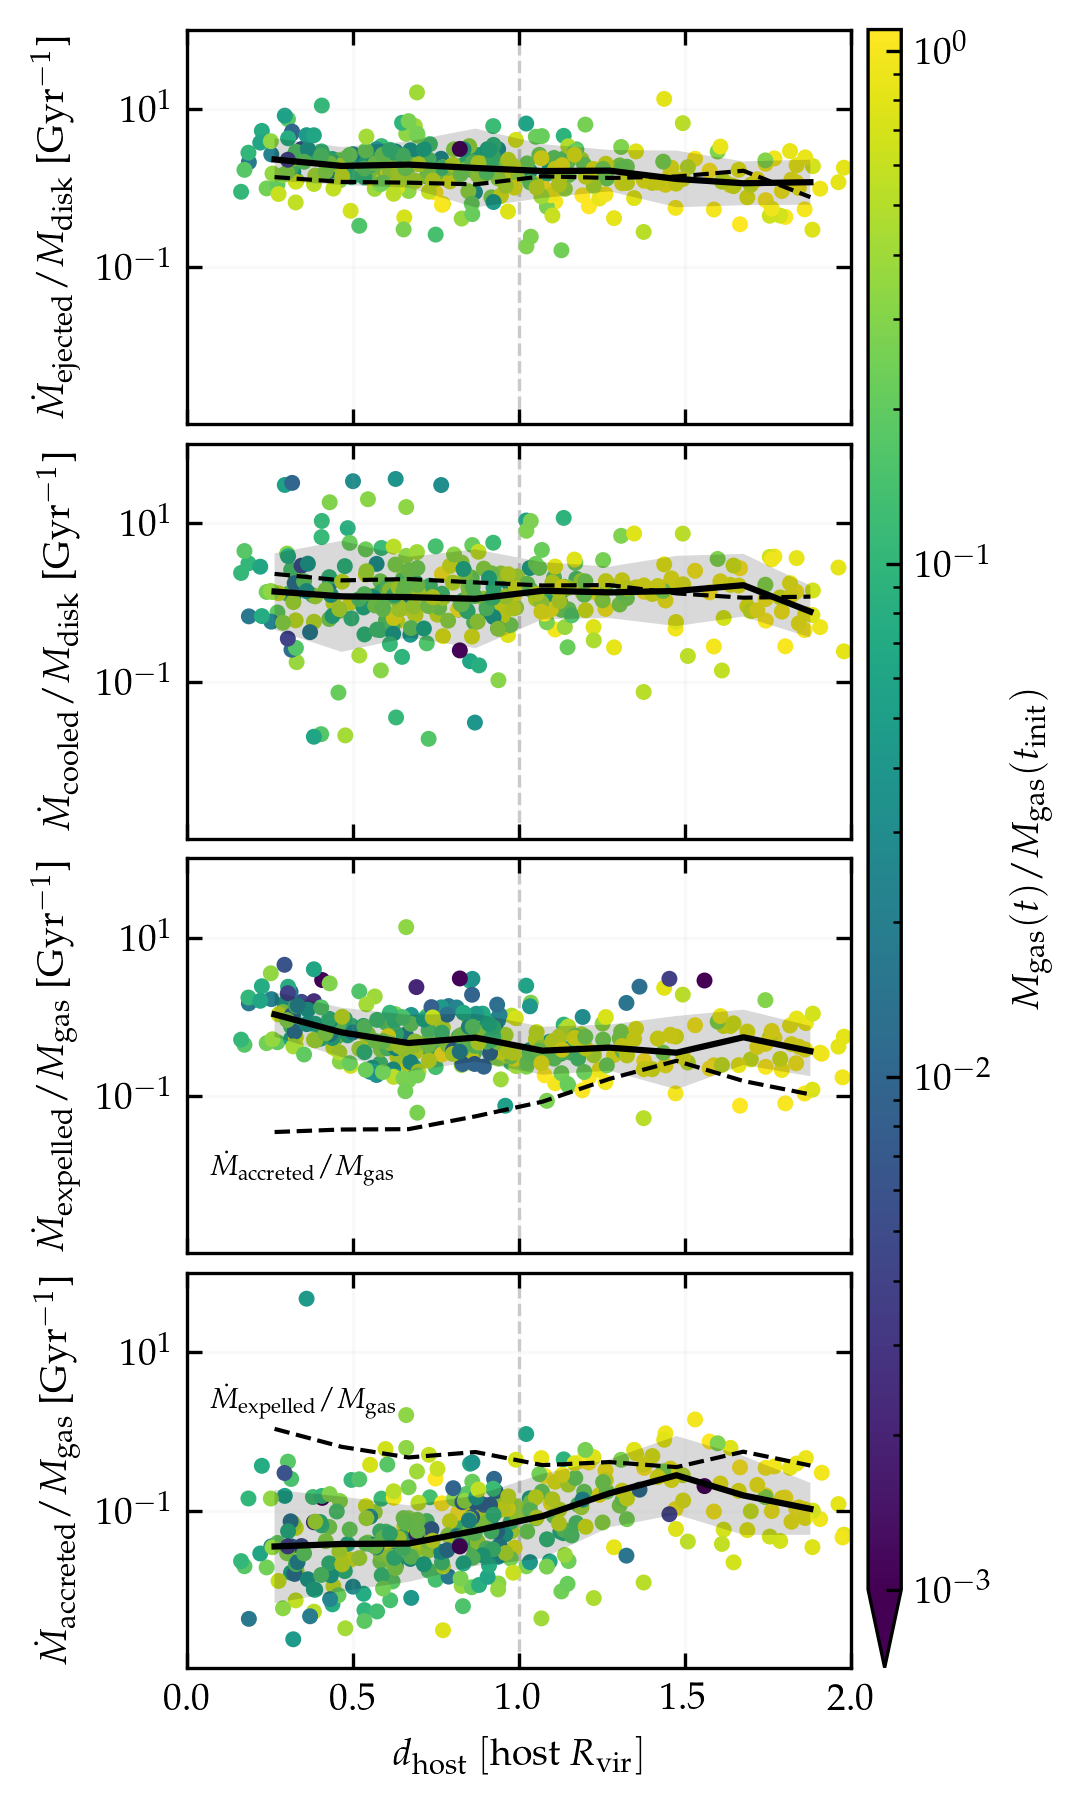

In [3]:
fig = plt.figure(dpi=300, figsize=(3.5, 6), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=4, ncols=2, width_ratios = [1,0.05], hspace=0.05, wspace=0.05)
gs.update(left=0.16, right=0.84, top=0.98, bottom=0.07)

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[3,0])
cax = plt.subplot(gs[:,1])
ax = [ax0,ax1,ax2,ax3]

x = data_all.h1dist/data_all.hostRvir
c = data_all.f_gas
# norm = mpl.colors.LogNorm()
norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1.1)

im = ax[0].scatter(x, data_all.Mdot_ejected_by_Mdisk, s=8, c=c, norm=norm)
im = ax[1].scatter(x, data_all.Mdot_cooled_by_Mdisk, s=8, c=c, norm=norm)
im = ax[2].scatter(x, data_all.Mdot_expelled_by_Mgas, s=8, c=c, norm=norm)
im = ax[3].scatter(x, data_all.Mdot_accreted_by_Mgas, s=8, c=c, norm=norm)
fig.colorbar(im, cax=cax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')

ax[0].plot_median(x, data_all.Mdot_ejected_by_Mdisk, logx=False, logy=True, std=True, color='k', bins=10)
ax[0].plot_median(x, data_all.Mdot_cooled_by_Mdisk, logx=False, logy=True, std=False, color='k', linestyle='--', linewidth=1, bins=10)

ax[1].plot_median(x, data_all.Mdot_cooled_by_Mdisk, logx=False, logy=True, std=True, color='k', bins=10)
ax[1].plot_median(x, data_all.Mdot_ejected_by_Mdisk, logx=False, logy=True, std=False, color='k', linestyle='--', linewidth=1, bins=10)

ax[2].plot_median(x, data_all.Mdot_expelled_by_Mgas, logx=False, logy=True, std=True, color='k', bins=10)
ax[2].plot_median(x, data_all.Mdot_accreted_by_Mgas, logx=False, logy=True, std=False, color='k', linestyle='--', linewidth=1, bins=10)
ax[2].annotate(r'$\dot{M}_{\rm accreted}/M_{\rm gas}$',(0.07, 1e-2), fontsize=7)

ax[3].plot_median(x, data_all.Mdot_accreted_by_Mgas, logx=False, logy=True, std=True, color='k', bins=10)
ax[3].plot_median(x, data_all.Mdot_expelled_by_Mgas, logx=False, logy=True, std=False, color='k', linestyle='--', linewidth=1, bins=10)
ax[3].annotate(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$',(0.07, 2), fontsize=7)

ax[0].set_ylabel(r'$\dot{M}_{\rm ejected}/M_{\rm disk}$ [Gyr$^{-1}$]')
ax[1].set_ylabel(r'$\dot{M}_{\rm cooled}/M_{\rm disk}$ [Gyr$^{-1}$]')
ax[2].set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax[3].set_ylabel(r'$\dot{M}_{\rm accreted}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax[3].set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')

for a in ax[:3]:
    a.tick_params(labelbottom=False)
    
mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)

for a in ax:
    a.semilogy()
    a.set_xlim(0, 2)
    a.set_ylim(1.05e-3, 1e2)
    a.grid(alpha=0.07, zorder=-1000)
    a.plot([1,1],[1e-3,1e3],color='0.8', linestyle='--', linewidth=0.8, zorder=-100)
    

# plt.savefig('plots/ejected_expelled.pdf')
plt.show()

## Quick sanity check: predicting gas mass <a class="anchor" id="sanity"></a>

If we've defined expulsion, accretion, etc properly, we should be able to predict the current gas mass of a saetllite based on its initial gas mass and the amount of material expelled/accreted since then. 

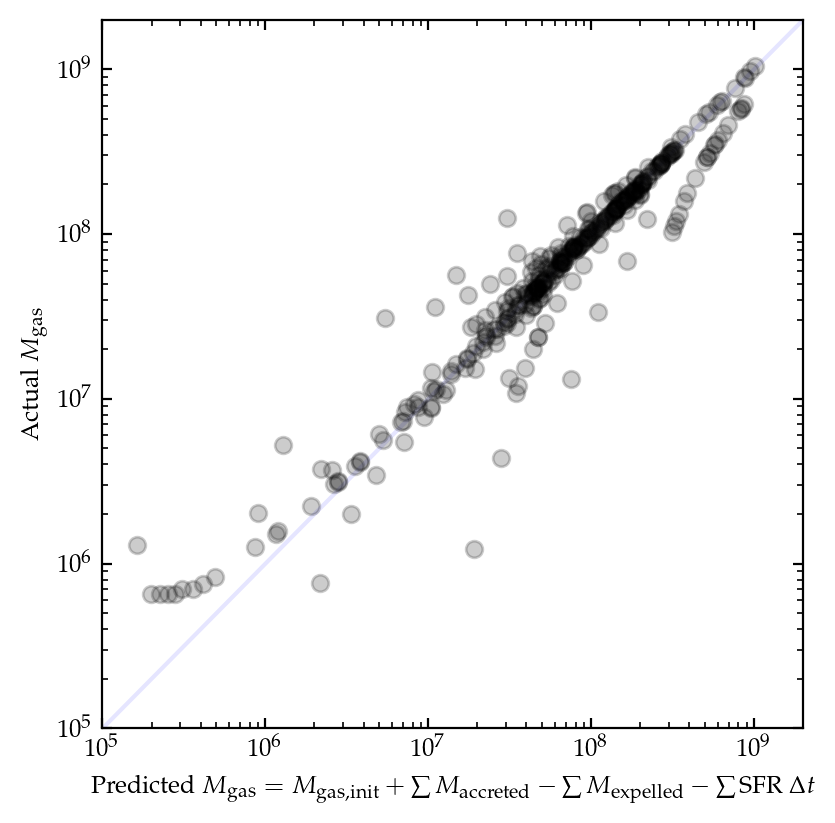

In [4]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(4, 4))

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('t')
    y = np.array(d.M_gas,dtype=float)
    Macc = np.array(d.M_accreted)
    Macc[np.isnan(Macc)] = 0
    Mexp = np.array(d.M_expelled)
    Mexp[np.isnan(Mexp)] = 0
    x = y[0] + np.cumsum(Macc)-np.cumsum(Mexp)- np.cumsum(d.SFR*d.dt*1e9)
    x = np.array(x,dtype=float)
    ax.scatter(x, y, c='k', alpha=0.2)
    
ax.set_ylabel(r'Actual $M_{\rm gas}$')
ax.set_xlabel(r'Predicted $M_{\rm gas} = M_{\rm gas,init} + \sum M_{\rm accreted} - \sum M_{\rm expelled}- \sum {\rm SFR}~\Delta t$')
ax.loglog()
ax.set_xlim(1e5, 2e9)
ax.set_ylim(1e5, 2e9)
ax.axline((1e5,1e5),(1e9,1e9), c='b', alpha=0.1, zorder=-100)

plt.show()

It seems to work pretty well, i.e. most points lie on the 1-1 line. There is some slight discrepancy in a few cases, likely due to weirdness in our integration of the star-formation rate (i.e. `dt` is not necessarily perfect).

We can also do the same thing for the disk:

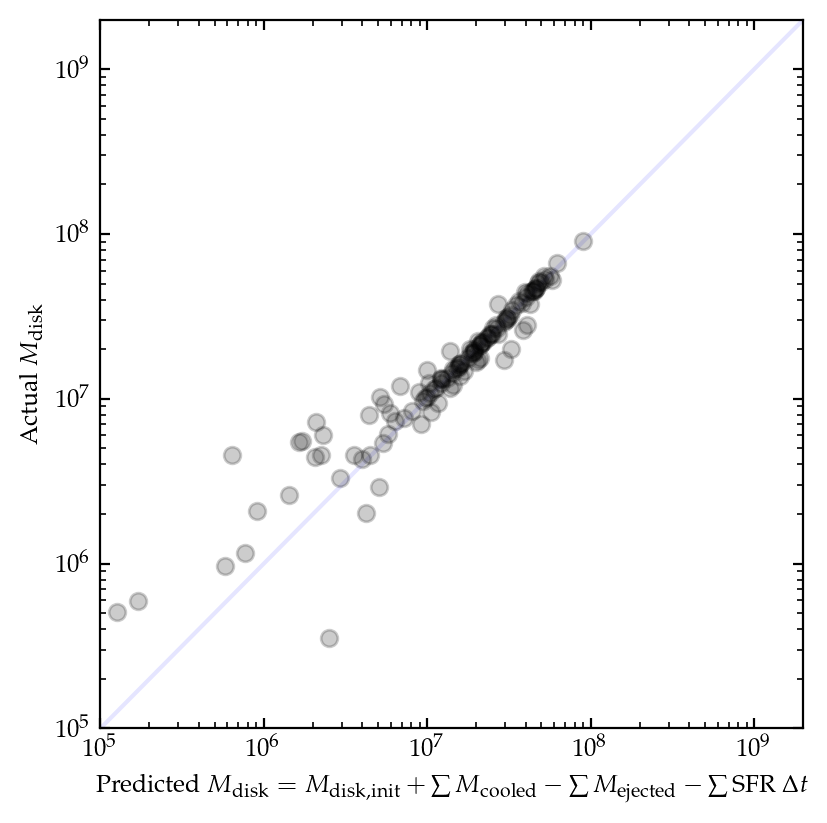

In [5]:
data = data_all[data_all.tau > 3.8]
data1 = data_all[data_all.tau <= 3.8]

fig, ax = plt.subplots(1,1,dpi=200, figsize=(4,4))

for key in np.unique(data1.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('t')
    y = np.array(d.M_disk,dtype=float)
    Mcoo = np.array(d.M_cooled)
    Mcoo[np.isnan(Mcoo)] = 0
    Meje = np.array(d.M_ejected)
    Meje[np.isnan(Meje)] = 0
    x = y[0] + np.cumsum(Mcoo)-np.cumsum(Meje)- np.cumsum(d.SFR*d.dt*1e9)
    x = np.array(x,dtype=float)
    ax.scatter(x, y, c='k', alpha=0.2)
    
ax.set_ylabel(r'Actual $M_{\rm disk}$')
ax.set_xlabel(r'Predicted $M_{\rm disk} = M_{\rm disk,init} + \sum M_{\rm cooled}  - \sum M_{\rm ejected} - \sum {\rm SFR}~\Delta t$')
ax.loglog()
ax.set_xlim(1e5, 2e9)
ax.set_ylim(1e5, 2e9)
ax.axline((1e5,1e5),(1e9,1e9), c='b', alpha=0.1, zorder=-100)

plt.show()

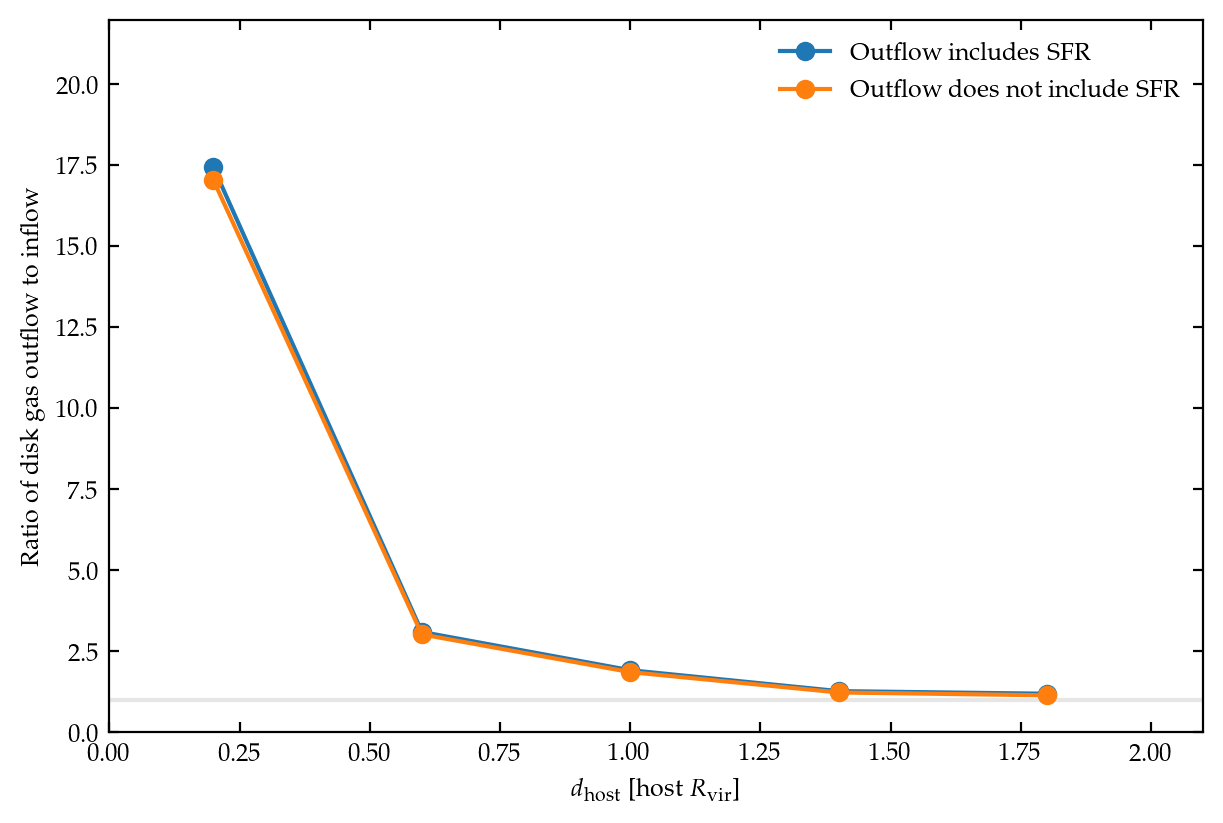

In [9]:
Mdot_disk = data_all.Mdot_cooled  - data_all.Mdot_ejected - data_all.SFR*1e9*data_all.dt
dist = np.array(data_all.h1dist/data_all.hostRvir)
bins = np.arange(0, 2.2, 0.4)

import scipy.stats
median_outflow, bins, binnumber= scipy.stats.binned_statistic(dist[Mdot_disk < 0], Mdot_disk[Mdot_disk < 0], bins=bins, statistic='sum')
median_inflow, bins, binnumber = scipy.stats.binned_statistic(dist[Mdot_disk > 0], Mdot_disk[Mdot_disk > 0], bins=bins, statistic='sum')
bc = 0.5*(bins[1:]+bins[:-1])

plt.figure(dpi=200)
plt.plot(bc, -median_outflow/median_inflow, 'o-', label='Outflow includes SFR')

Mdot_disk = data_all.Mdot_cooled  - data_all.Mdot_ejected
median_outflow, bins, binnumber= scipy.stats.binned_statistic(dist[Mdot_disk < 0], Mdot_disk[Mdot_disk < 0], bins=bins, statistic='sum')
median_inflow, bins, binnumber = scipy.stats.binned_statistic(dist[Mdot_disk > 0], Mdot_disk[Mdot_disk > 0], bins=bins, statistic='sum')
plt.plot(bc, -median_outflow/median_inflow, 'o-', label='Outflow does not include SFR')

# plt.semilogy()
plt.ylim(0, 22)
plt.xlim(0,2.1)
plt.legend()
plt.axline((0,1), (2,1), color='0.9', zorder=-100)
plt.ylabel(r'Ratio of disk gas outflow to inflow')
plt.xlabel(r'$d_{\rm host}$ [host $R_{\rm vir}$]')
plt.show()

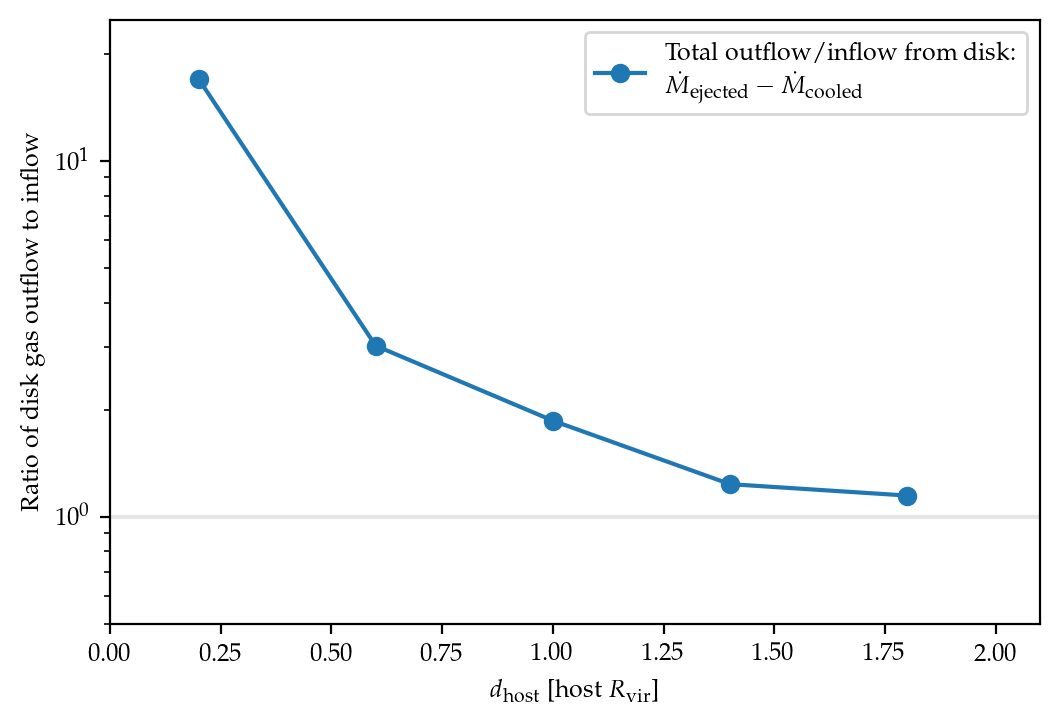

In [637]:
Mdot_disk = data_all.Mdot_cooled  - data_all.Mdot_ejected
dist = np.array(data_all.h1dist/data_all.hostRvir)
bins = np.arange(0, 2.2, 0.4)

import scipy.stats
median_outflow, bins, binnumber= scipy.stats.binned_statistic(dist[Mdot_disk < 0], Mdot_disk[Mdot_disk < 0], bins=bins, statistic='sum')
median_inflow, bins, binnumber = scipy.stats.binned_statistic(dist[Mdot_disk > 0], Mdot_disk[Mdot_disk > 0], bins=bins, statistic='sum')
bc = 0.5*(bins[1:]+bins[:-1])

plt.figure(dpi=200)
plt.plot(bc, -median_outflow/median_inflow, 'o-', label='Total outflow/inflow from disk: \n' + r'$\dot{M}_{\rm ejected} - \dot{M}_{\rm cooled}$')

plt.semilogy()
plt.ylim(1/2, 25)
plt.xlim(0,2.1)
plt.legend()
plt.axline((0,1), (2,1), color='0.9', zorder=-100)
plt.ylabel(r'Ratio of disk gas outflow to inflow')
plt.xlabel(r'$d_{\rm host}$ [host $R_{\rm vir}$]')
plt.show()

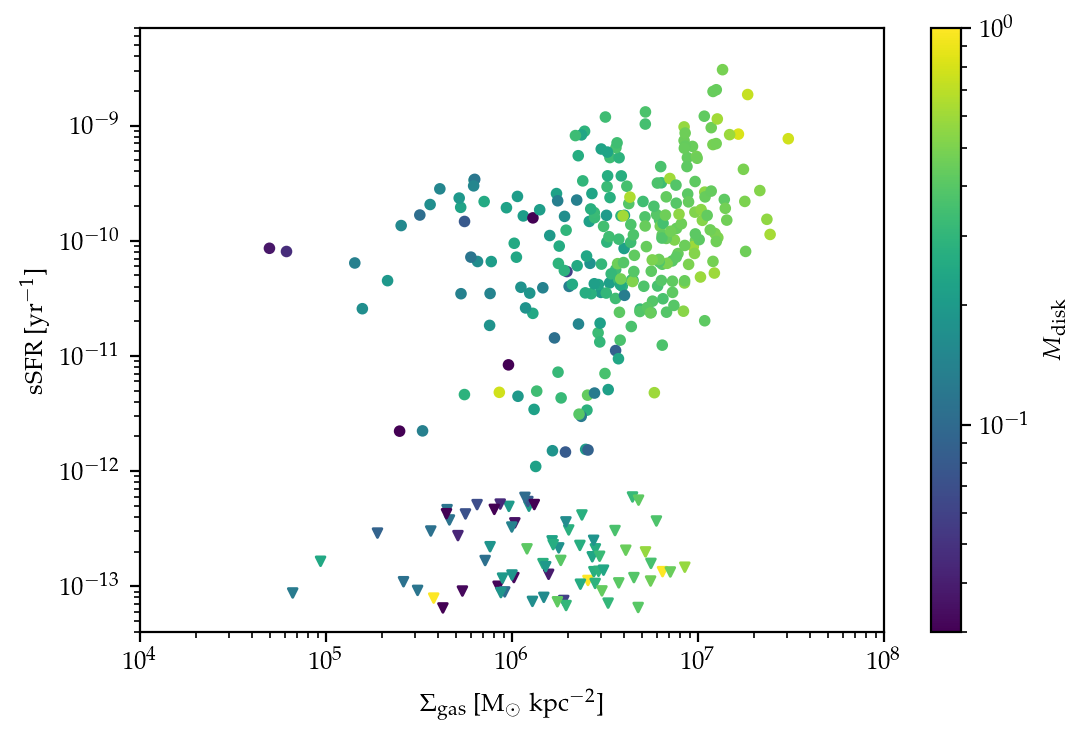

In [270]:
plt.figure(dpi=200)
plt.scatter(data_all.SigmaGas, data_all.sSFR, c=data_all.M_disk/data_all.M_gas, norm=mpl.colors.LogNorm(vmin=3e-2, vmax=1), s=10)


plt.scatter(data_all.SigmaGas[data_all.sSFR==0], 10**np.random.uniform(low=-13.2, high=-12.2, size=len(data_all[data_all.sSFR==0])), s=10, 
                c=(data_all.M_disk/data_all.M_gas)[data_all.sSFR==0], norm=mpl.colors.LogNorm(vmax=1, vmin=3e-2), marker='v')

plt.loglog()
plt.xlim(1e4,1e8)
plt.ylim(4e-14,7e-9)
plt.xlabel(r'$\Sigma_{\rm gas}$ [M$_{\odot}$ kpc$^{-2}$]')
plt.ylabel(r'sSFR [yr$^{-1}$]')
plt.colorbar(label=r'$M_{\rm disk}$')
plt.show()

In [218]:
median_inflow

array([4.31451658e+07, 1.76672134e+09, 1.72383196e+09, 8.10367735e+08,
       2.76355982e+07, 5.08329663e+08])

(array([  0.,  19.,  91., 143.,  90.,  24.,   8.,   2.]),
 array([-5, -4, -3, -2, -1,  0,  1,  2,  3]),
 <BarContainer object of 8 artists>)

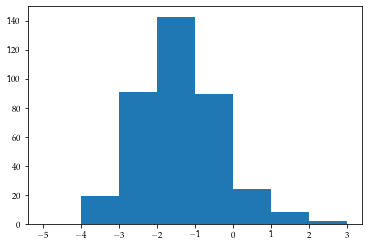

In [204]:
plt.hist(np.log10(dist), bins=np.arange(-5, 4, 1))

In [199]:
median_inflow

array([4.31451658e+07, 1.45218877e+09, 1.97104909e+09, 4.04777947e+08,
       5.00540830e+08, 0.00000000e+00])

In [144]:
median_outflow

array([-33821939.21312684, -59316199.55154607, -50304053.50481827,
       -32750073.45050506, -23085133.88820319, -56874056.75366367,
       -25970798.25069635, -50331657.04224064])

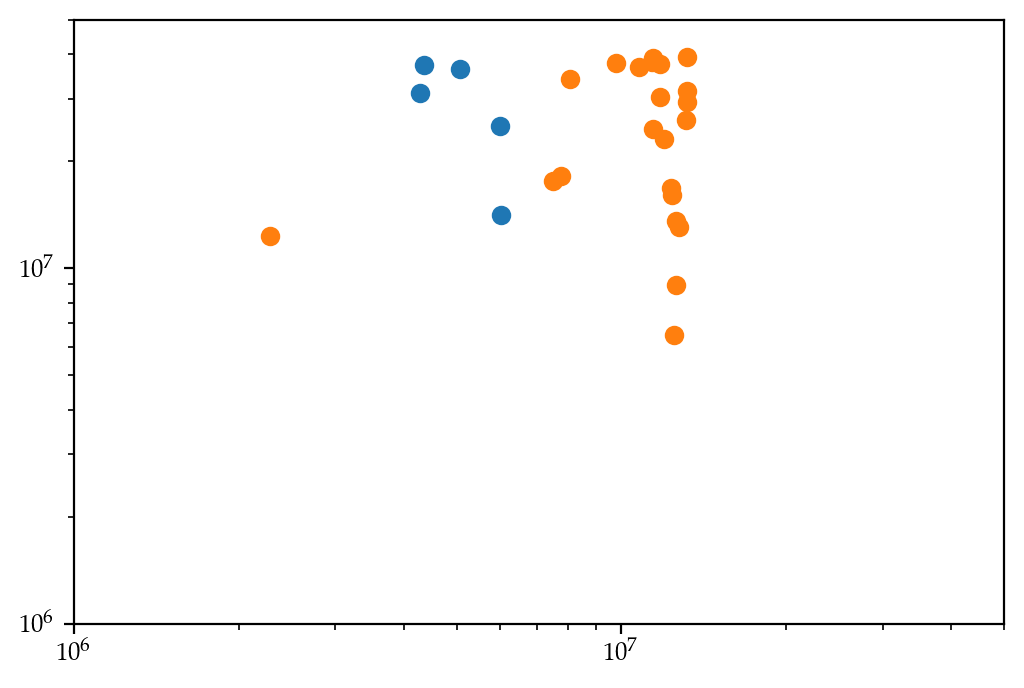

In [632]:
plt.figure(dpi=200)
plt.scatter(np.cumsum(d.SFR*d.dt * 1e9), np.cumsum(d.M_ejected - d.M_cooled), label='net ejection')
plt.scatter(np.cumsum(d.SFR*d.dt * 1e9), -np.cumsum(d.M_ejected - d.M_cooled), label='net cooling')
plt.loglog()
plt.xlim(1e6, 5e7)
plt.ylim(1e, 5e7)
plt.show()


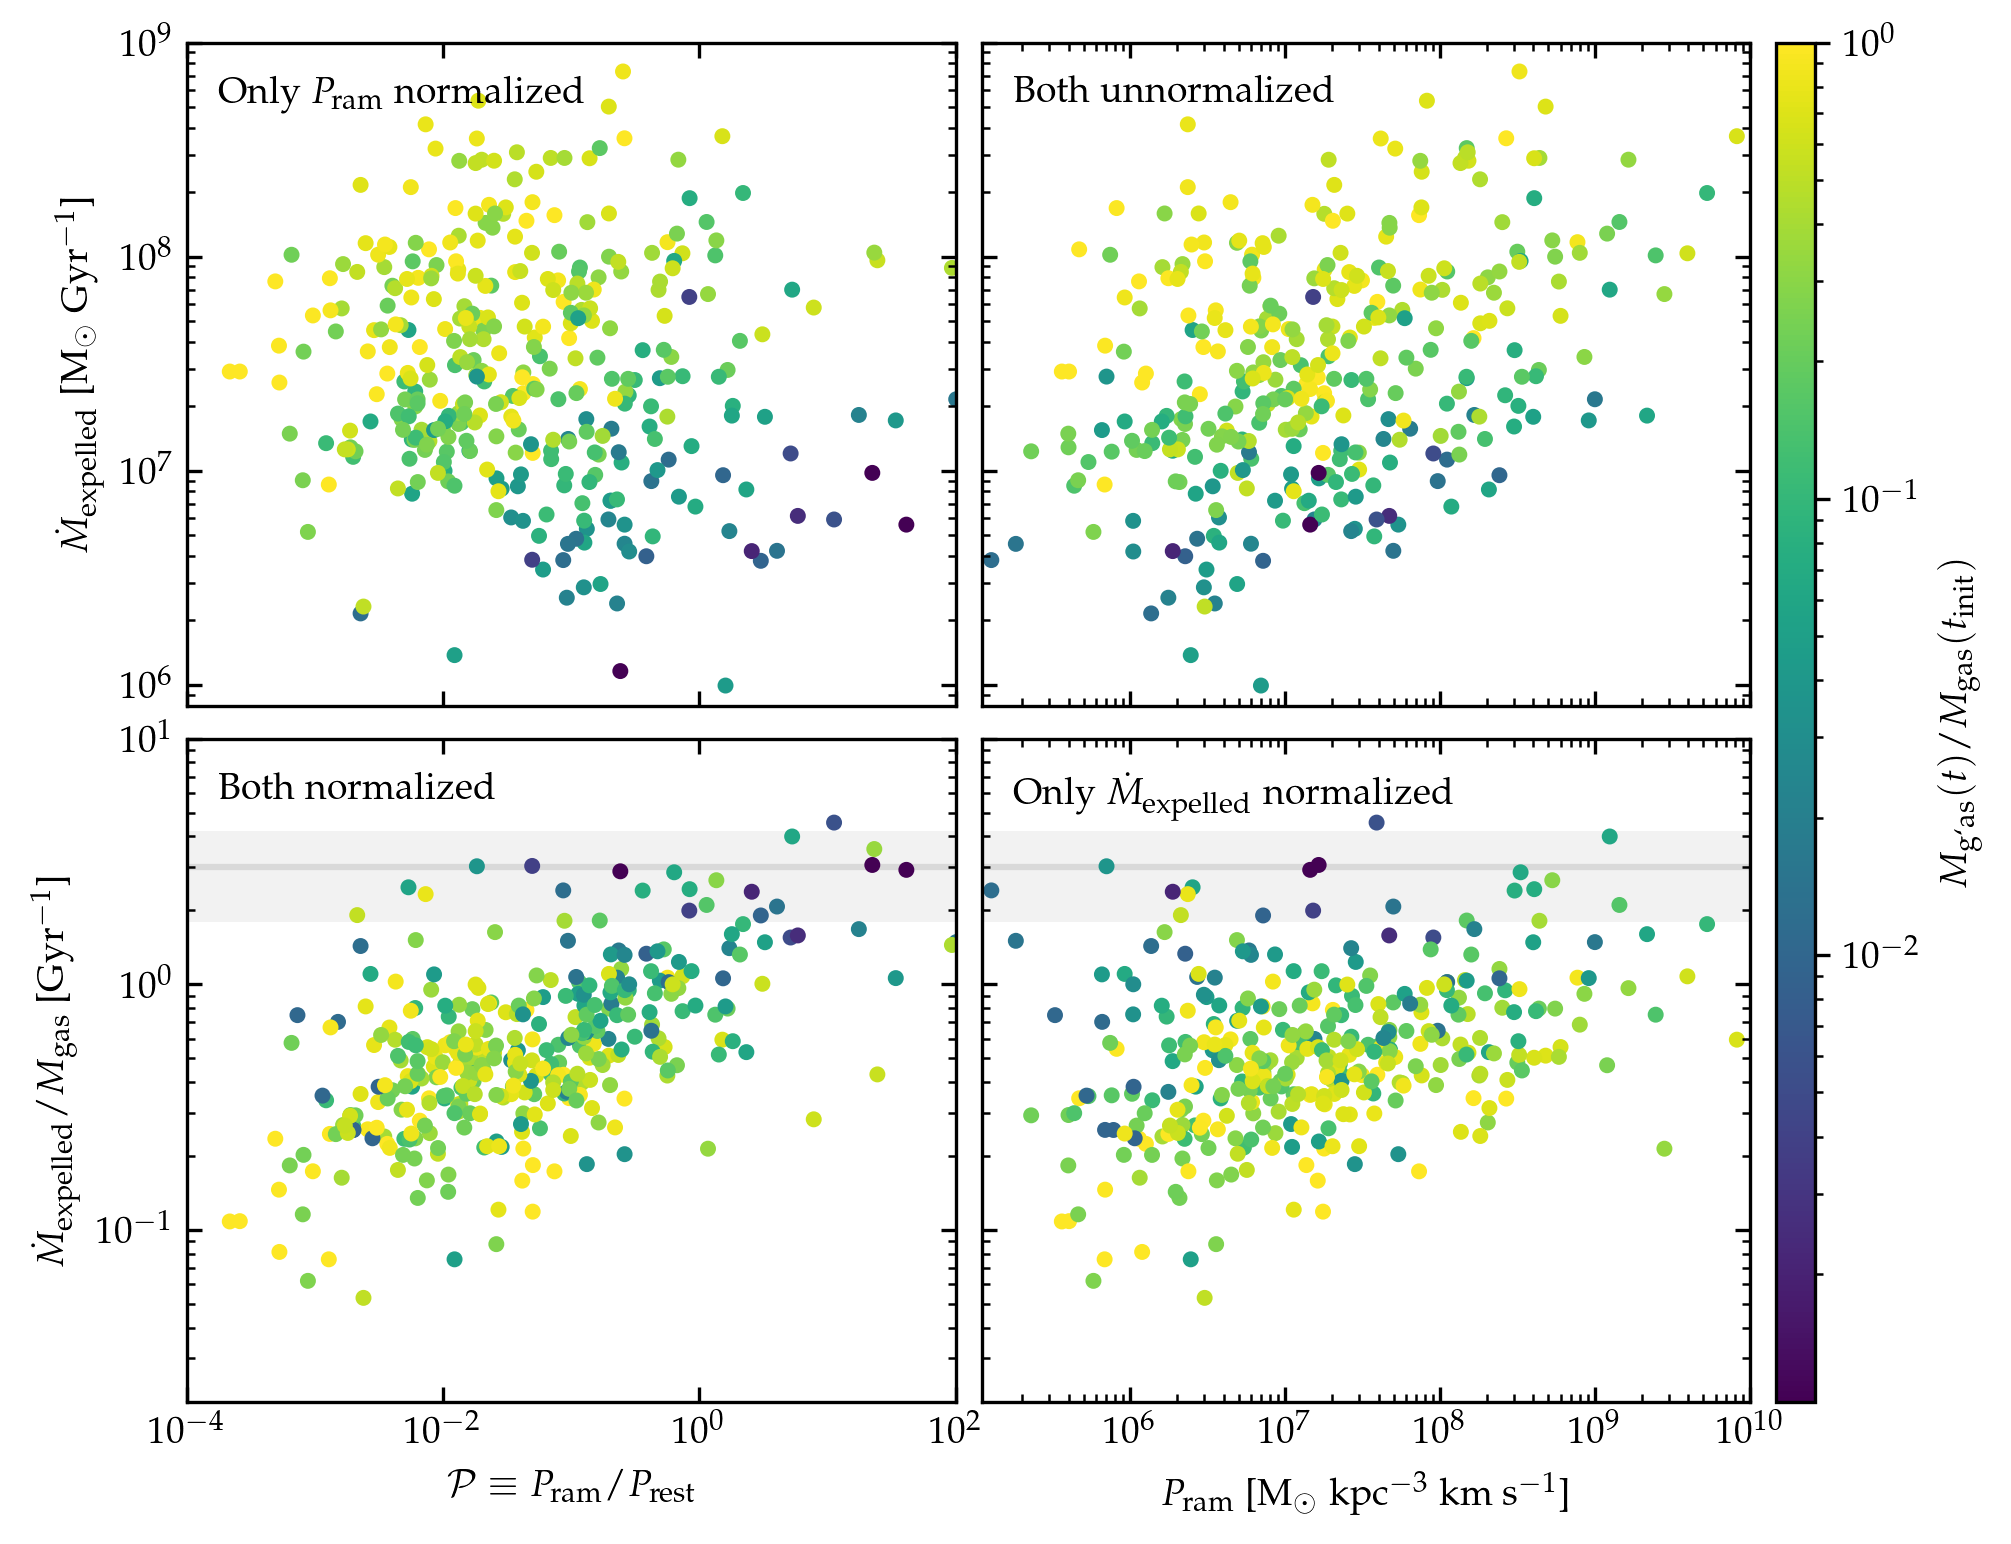

In [17]:
fig = plt.figure(dpi=300, figsize=(7,6))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[1,1,0.05])
gs.update(hspace=0.05, wspace=0.05)

rax0 = plt.subplot(gs[0,0])
rax1 = plt.subplot(gs[1,0])
Pax0 = plt.subplot(gs[0,1])
Pax1 = plt.subplot(gs[1,1])
cbax = plt.subplot(gs[:,2])
c = data_all.f_gas
norm = mpl.colors.LogNorm(vmax=1, vmin=1.05e-3)

im = rax0.scatter(data_all.ratio, data_all.Mdot_expelled, s=8, c=c, norm=norm)
rax0.set_ylabel(r'$\dot{M}_{\rm expelled}$ [M$_{\odot}$ Gyr$^{-1}$]')
rax0.loglog()
rax0.set_xlim(1e-4, 1e2)
rax0.set_ylim(8e5, 1e9)

im = rax1.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=c, norm=norm)
rax1.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
rax1.set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
rax1.loglog()
rax1.set_xlim(1e-4, 1e2)
rax1.set_ylim(2e-2, 1e1)
rax1.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
rax1.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)

im = Pax0.scatter(data_all.Pram_adv, data_all.Mdot_expelled, s=8, c=c, norm=norm)
Pax0.loglog()
Pax0.set_xlim(1.1e5, 1e10)
Pax0.set_ylim(8e5, 1e9)

im = Pax1.scatter(data_all.Pram_adv, data_all.Mdot_expelled_by_Mgas, s=8, c=c, norm=norm)
Pax1.set_xlabel(r'$P_{\rm ram}$ [M$_{\odot}$ kpc$^{-3}$ km s$^{-1}$]')
Pax1.loglog()
Pax1.set_xlim(1.1e5, 1e10)
Pax1.set_ylim(2e-2, 1e1)
Pax1.plot([1e5,1e10],[3,3],color='0.85', zorder=-90)
Pax1.fill_between([1e5,1e10],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)

Pax1.tick_params(direction='in', which='both', top=True, right=True, labelleft=False)
Pax0.tick_params(direction='in', which='both', top=True, right=True, labelleft=False, labelbottom=False)
rax0.tick_params(direction='in', which='both', top=True, right=True, labelbottom=False)
rax1.tick_params(direction='in', which='both', top=True, right=True)

fig.colorbar(im, cax=cbax, label=r'$M_{\rm g`as}(t)/M_{\rm gas}(t_{\rm init})$')

rax0.annotate(r'Only $P_{\rm ram}$ normalized', (0.04, 0.95), xycoords='axes fraction', va='top')
rax1.annotate('Both normalized', (0.04, 0.95), xycoords='axes fraction', va='top')
Pax0.annotate('Both unnormalized', (0.04, 0.95), xycoords='axes fraction', va='top')
Pax1.annotate(r'Only $\dot{M}_{\rm expelled}$ normalized', (0.04, 0.95), xycoords='axes fraction', va='top')

plt.show()

Deciding what plot to use: 

1. Only $P_{\rm ram}$ normalized. 
    - This plot shows that expulsion rates go down with increasing ram pressure. While that may be true, this is really because satellites with very low gas mass (that have high $P_{\rm rest}$ don't have much to expel. This makes this plot not very useful. 
2. Both normalized
    - This plot shows a power-law relationship of increasing expulsion rates with increasing ram pressure ratio. However, this is almost by construction, since satellites with low gas mass will always appear in the top-right, and these points carry most of the visual weight of the linear relationship. 
3. Both unnormalized
    - This plot shows a similar power-law relationship but you have to do the normalization yourself, by eye. It seems that there is a relationship between x and y at constant $f_{\rm gas}$.
4. Only $\dot{M}_{\rm expelled}$ normalized. 
    - This plot still shows the basic power-law trend of plot 2, but the low gas mass satellites aren't concentrated in any particular part of the plot. 
    

Overall: 
- I want to normalize by $M_{\rm gas}$ because I want to be able to interpret these as depletion times. However, that may be more useful in a plot with net expulsion-accretion, since we could theoretically relate that to the quenching timescales. 
- I want to normalize by $P_{\rm rest}$ since thats common in the literature and I'm considering using $P_{\rm rest}$ to make an argument about the role of tidal stripping (in decreasing restoring pressure). 

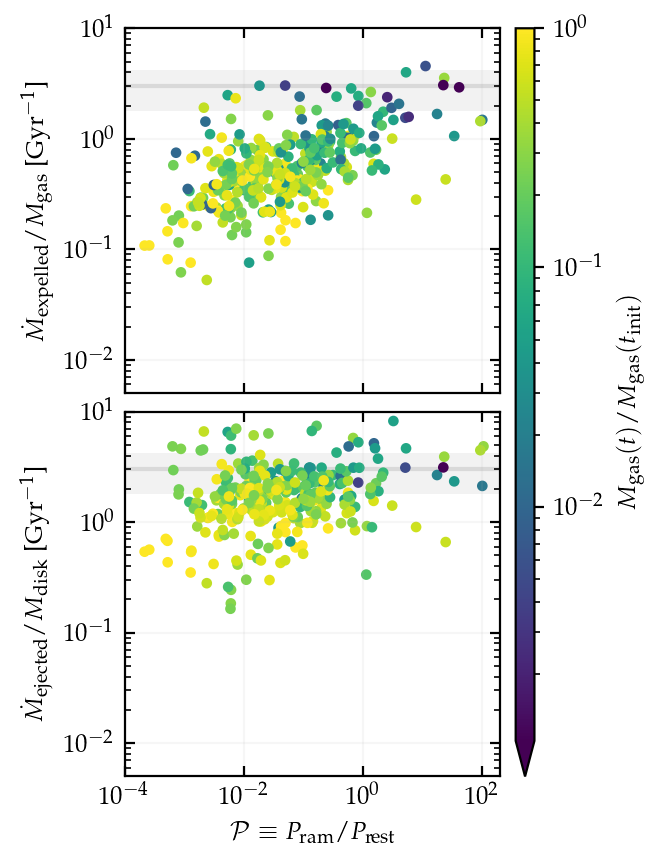

In [639]:
fig = plt.figure(dpi=200, figsize=(3.2,4.3))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, width_ratios = [1,0.05])
cax = plt.subplot(gs[:,1])

ax = plt.subplot(gs[0,0])

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3))
# ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(5e-3, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True, labelbottom=False)
ax.grid(alpha=0.1, zorder=-1000)

ax = plt.subplot(gs[1,0])

im = ax.scatter(data_all.ratio, data_all.Mdot_ejected_by_Mdisk, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3))
fig.colorbar(im, cax=cax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm ejected}/M_{\rm disk}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(5e-3, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)


plt.subplots_adjust(left=0.18, top=0.97, right=0.82, bottom=0.1, hspace=0.05, wspace=0.08)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

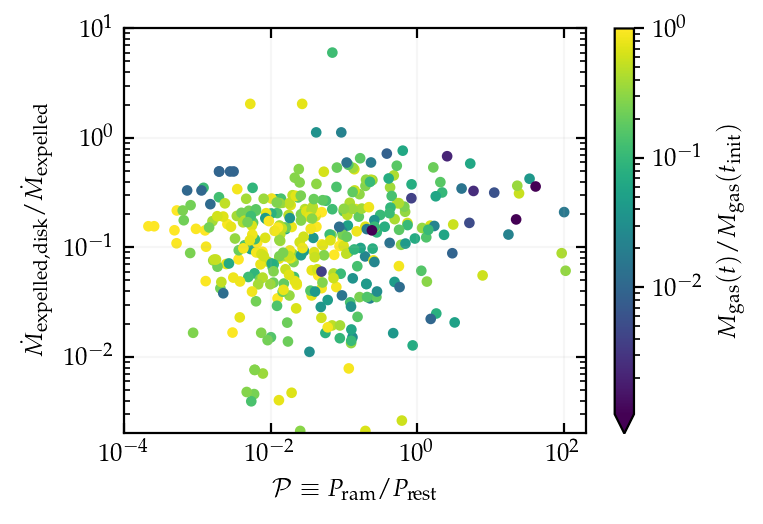

In [133]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_disk/data_all.Mdot_expelled, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3))
fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled,disk}/\dot{M}_{\rm expelled}$')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(2e-3, 1e1)
# ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
# ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)


plt.subplots_adjust(left=0.15, top=0.96, right=0.93, bottom=0.15, hspace=0.05)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

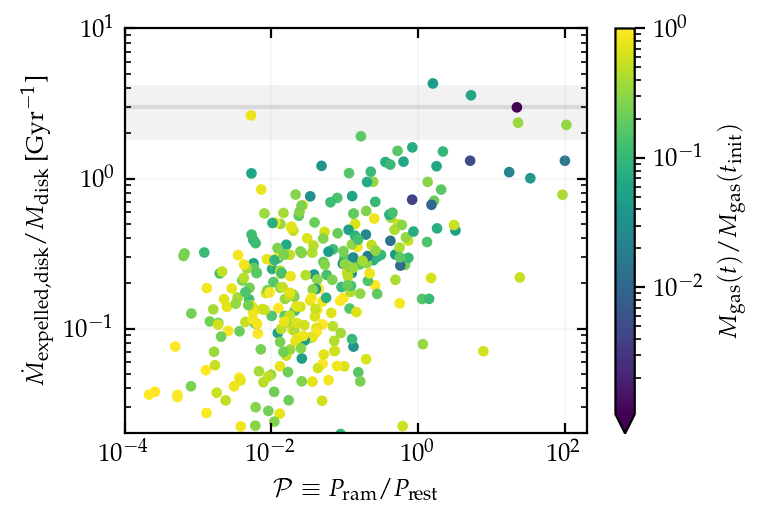

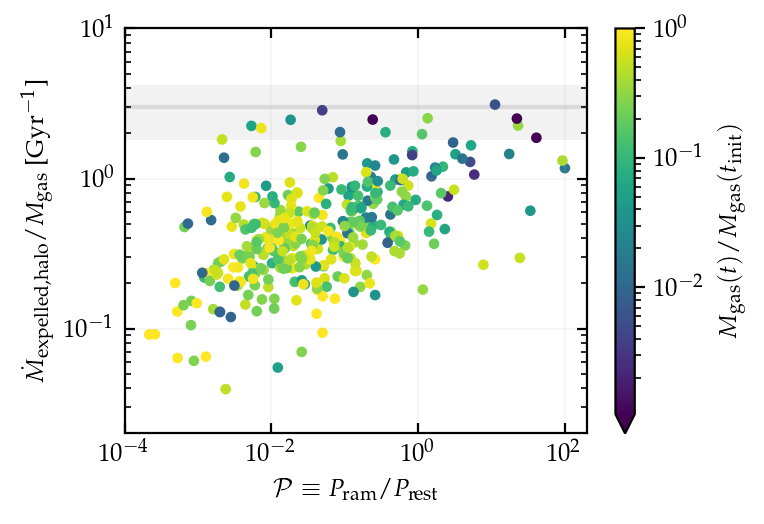

In [131]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_disk_by_Mdisk, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3))
fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled,disk}/M_{\rm disk}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(2e-2, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)


plt.subplots_adjust(left=0.15, top=0.96, right=0.93, bottom=0.15, hspace=0.05)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas - data_all.Mdot_expelled_disk_by_Mgas, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3))
fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled,halo}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 2e2)
ax.set_ylim(2e-2, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)


plt.subplots_adjust(left=0.15, top=0.96, right=0.93, bottom=0.15, hspace=0.05)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

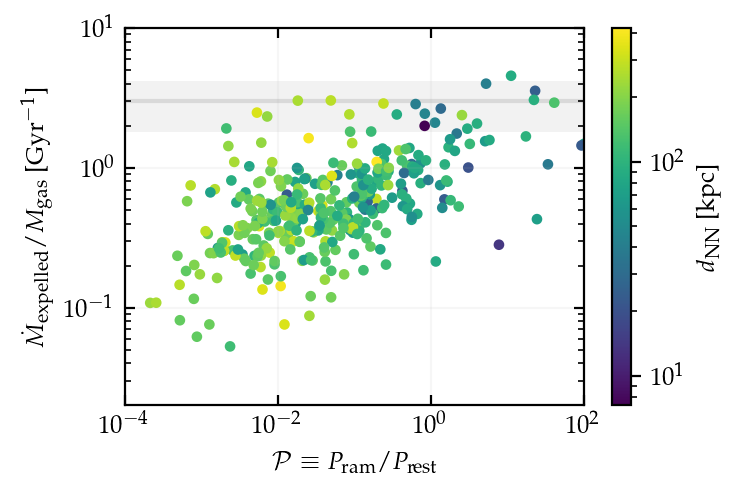

In [19]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=data_all.dNN, norm=mpl.colors.LogNorm())
fig.colorbar(im, ax=ax, label=r'$d_{\rm NN}$ [kpc]')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(2e-2, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

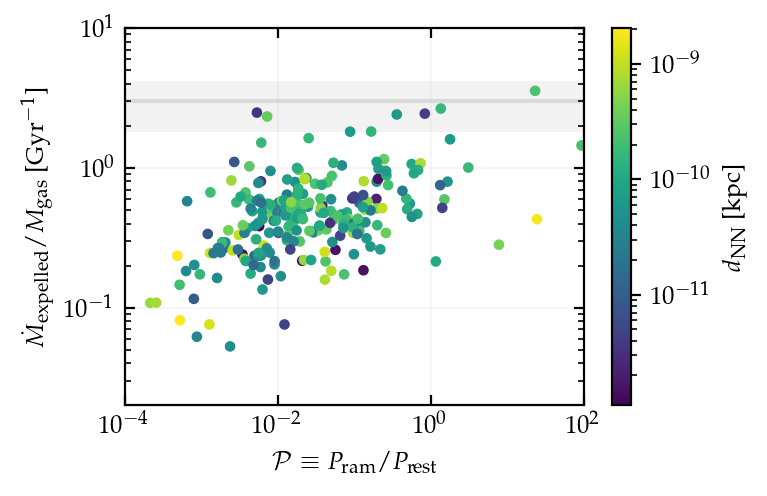

In [20]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(data_all.ratio, data_all.Mdot_expelled_by_Mgas, s=8, c=data_all.sSFR, norm=mpl.colors.LogNorm())
fig.colorbar(im, ax=ax, label=r'$d_{\rm NN}$ [kpc]')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(2e-2, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

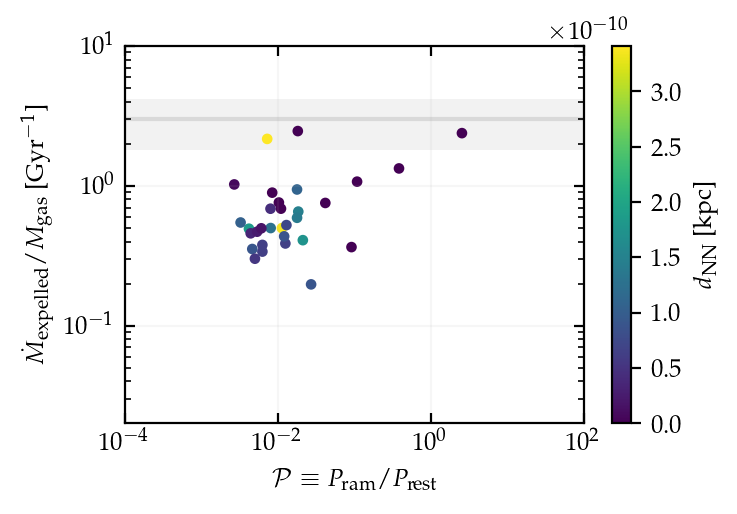

In [731]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(data_all.ratio[data_all.key=='h242_24'], data_all.Mdot_expelled_by_Mgas[data_all.key=='h242_24'], s=8, c=data_all.sSFR[data_all.key=='h242_24'], norm=mpl.colors.Log())
fig.colorbar(im, ax=ax, label=r'$d_{\rm NN}$ [kpc]')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(2e-2, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

In [21]:
h148 = read_timesteps('h148')
h148['sim'] = 'h148'
h229 = read_timesteps('h229')
h229['sim'] = 'h229'
h242 = read_timesteps('h242')
h242['sim'] = 'h242'
h329 = read_timesteps('h329')
h329['sim'] = 'h329'
timesteps_all = pd.concat([h148,h229,h242,h329])

In [22]:
def get_halo_masses(d):
    global timesteps_all
    sim = str(d.key)[:4]
    haloid = int(str(d.key)[5:])
    t = float(d.t)
    ts = timesteps_all[(timesteps_all.z0haloid==haloid)&(timesteps_all.sim==sim)]
    ts = ts[ts.z0haloid==haloid]
    times = np.array(ts.time, dtype=float)
    M_halos = np.array(ts.mass-ts.mgas-ts.mstar, dtype=float)
    M_halo = M_halos[np.argmin(np.abs(times-t))]
    d['M_halo'] = M_halo
    d['M_halo_peak'] = np.max(M_halos)
    d['M_gas_peak'] = np.max(ts.mgas)
    return d
    
from tqdm import tqdm
tqdm.pandas()
data_all = data_all.progress_apply(get_halo_masses, axis=1)

/Users/hollis/anaconda3/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 512/512 [00:04<00:00, 102.51it/s]


In [337]:
len(np.unique(data_all.key[data_all.ratio > 1]))

15

## Fraction of gas mass expelled at different ram pressure ratios, and expulsion probabilities

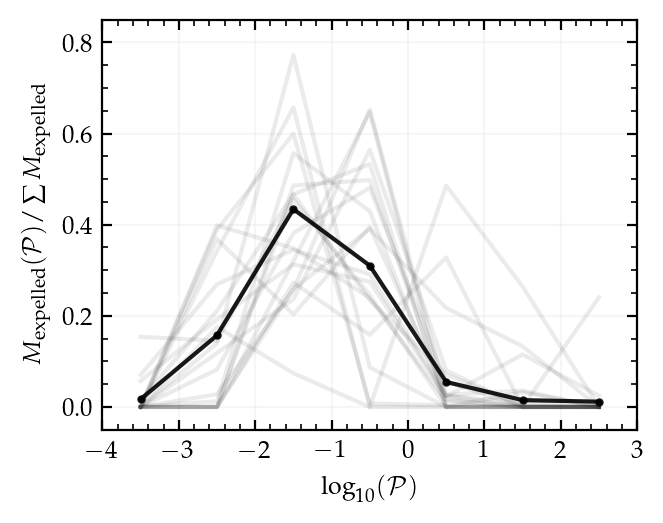

In [640]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.2,2.5), constrained_layout=True)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = np.log10(d.ratio)
    y = d.M_expelled
    cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
    BigSum = np.sum(y[cond])
    Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=np.arange(-4, 4, 1))
    bc = 0.5*(bins[1:]+bins[:-1])
    ax.plot(bc, Sum/BigSum, 'k-', ms=2, alpha=0.08)

x = np.log10(data_all.ratio)
y = data_all.M_expelled
cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
BigSum = np.sum(y[cond])
Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=np.arange(-4, 4, 1))
bc = 0.5*(bins[1:]+bins[:-1])
im = ax.plot(bc, Sum/BigSum, 'ko-', ms=2, alpha=0.9)
    
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$M_{\rm expelled}(\mathcal{P})/\sum M_{\rm expelled}$')
ax.set_xlim(-4, 3)
ax.set_ylim(-0.05, 0.85)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

# plt.savefig('plots/fraction_expelled_by_Pram.pdf')
plt.show()

This is roughly equivalent to just a histogram of the number of snapshots we observe at different $\mathcal{P}$. However, we see less mass expulsion between -3 and -2, and more between -1 and 0, than we would expect from the histogram.

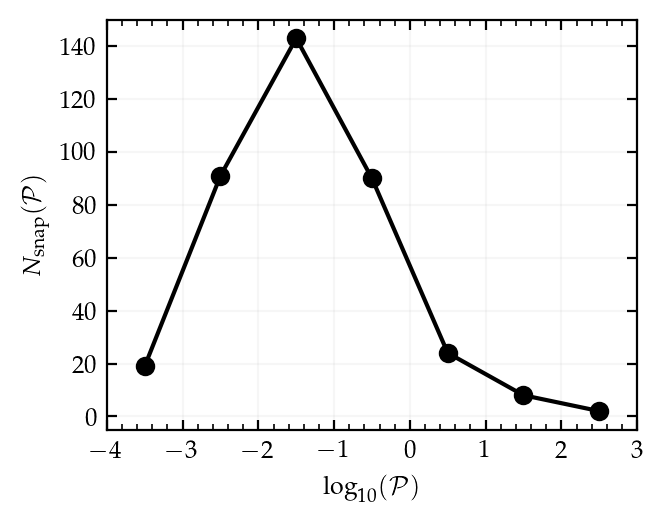

In [641]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.2,2.5), constrained_layout=True)

N, bins = np.histogram(np.log10(data_all.ratio), bins=np.arange(-4, 4, 1))
bc = 0.5*(bins[1:]+bins[:-1])
im = ax.plot(bc, N, 'ko-')
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$N_{\rm snap}(\mathcal{P})$')
ax.set_xlim(-4, 3)
# ax.set_ylim(-0.05, 0.85)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

The different shapes of these two curves is a result of the different probability of expulsion at different ram pressure ratios. We can calculate that probability as the number of particles that have just been expelled, at some time $t_2$, divided by the number of particles in the satellite at the previous snapshot of time $t_1$. 

In [642]:
import warnings
warnings.filterwarnings("ignore")

ratios, N_e, N_p, E_prob = np.array([]),np.array([]),np.array([]),np.array([])
ratios_disk, N_e_disk, N_p_disk, E_prob_disk = np.array([]),np.array([]),np.array([]),np.array([])
for key in np.unique(data_all.key):
    print(key, end=' ')
    d = data_all[data_all.key==key]
    
    # full satellite
    expelled = pd.read_hdf(f'../../Data/expelled_particles.hdf5', key=key)
    particles = read_tracked_particles(key[:4],int(key[5:]))
    particles = particles[particles.in_sat]

    expelled_merged = pd.merge_asof(expelled.sort_values('time'), d.sort_values('t'), left_on='time', right_on='t')
    particles_merged = pd.merge_asof(particles.sort_values('time'), d.sort_values('t'), left_on='time', right_on='t')

    times = np.unique(particles_merged.t)
    ratios1 = np.array(particles_merged.groupby(['t']).ratio.median().reset_index()['ratio'])
    N_e1 = np.array([len(expelled_merged[expelled_merged.time==t2]) for t2 in times[1:]])
    N_p1 = np.array([len(particles_merged[particles_merged.time==t1]) for t1 in times[:-1]])
    E_prob1 = N_e1/N_p1
    ratios1 = ratios1[1:]
    
    ratios = np.append(ratios,ratios1)
    N_e = np.append(N_e, N_e1)
    N_p = np.append(N_p, N_p1)
    E_prob = np.append(E_prob, E_prob1)
    
    # disk
    expelled = pd.read_hdf(f'../../Data/expelled_particles.hdf5', key=key)
    expelled = expelled[expelled.state1=='sat_disk']
    particles = read_tracked_particles(key[:4],int(key[5:]))
    particles = particles[particles.sat_disk]

    expelled_merged = pd.merge_asof(expelled.sort_values('time'), d.sort_values('t'), left_on='time', right_on='t')
    particles_merged = pd.merge_asof(particles.sort_values('time'), d.sort_values('t'), left_on='time', right_on='t')

    times = np.unique(particles_merged.t)
    ratios1 = np.array(particles_merged.groupby(['t']).ratio.median().reset_index()['ratio'])
    N_e1 = np.array([len(expelled_merged[expelled_merged.time==t2]) for t2 in times[1:]])
    N_p1 = np.array([len(particles_merged[particles_merged.time==t1]) for t1 in times[:-1]])
    E_prob1 = N_e1/N_p1
    ratios1 = ratios1[1:]
    
    ratios_disk = np.append(ratios_disk,ratios1)
    N_e_disk = np.append(N_e_disk, N_e1)
    N_p_disk = np.append(N_p_disk, N_p1)
    E_prob_disk = np.append(E_prob_disk, E_prob1)

h148_13 

AttributeError: 'DataFrame' object has no attribute 'state1'

In [519]:
cond = ~np.isnan(E_prob) & ~np.isinf(E_prob)
ratios = ratios[cond]
N_e = N_e[cond]
N_p = N_p[cond]
E_prob = E_prob[cond]
cond_disk = ~np.isnan(E_prob_disk) & ~np.isinf(E_prob_disk)
ratios_disk = ratios_disk[cond_disk]
N_e_disk = N_e_disk[cond_disk]
N_p_disk = N_p_disk[cond_disk]
E_prob_disk = E_prob_disk[cond_disk]

In [520]:
bins = np.append(np.arange(-4,2,1),2.2)
bc = 0.5*(bins[1:] + bins[:-1])
E_prob_median, E_prob_weighted, E_prob_weighted_log, std = np.array([]),np.array([]),np.array([]),np.array([])
E_prob_median_disk, E_prob_weighted_disk, E_prob_weighted_log_disk, std_disk = np.array([]),np.array([]),np.array([]),np.array([])
for left_edge, right_edge in zip(bins[:-1],bins[1:]):
    cond = (np.log10(ratios) >= left_edge) & (np.log10(ratios) < right_edge)
    E_prob_weighted = np.append(E_prob_weighted,np.average(E_prob[cond], weights=N_p[cond]))
    E_prob_weighted_log = np.append(E_prob_weighted_log,np.average(E_prob[cond], weights=np.log10(N_p)[cond]))
    E_prob_median = np.append(E_prob_median,np.median(E_prob[cond]))
    std = np.append(std, np.std(E_prob[cond]))
    
    cond = (np.log10(ratios_disk) >= left_edge) & (np.log10(ratios_disk) < right_edge)
    E_prob_weighted_disk = np.append(E_prob_weighted_disk,np.average(E_prob_disk[cond], weights=N_p_disk[cond]))
    E_prob_weighted_log_disk = np.append(E_prob_weighted_log_disk,np.average(E_prob_disk[cond], weights=np.log10(N_p_disk)[cond]))
    E_prob_median_disk = np.append(E_prob_median_disk,np.median(E_prob_disk[cond]))
    std_disk = np.append(std_disk, np.std(E_prob_disk[cond]))

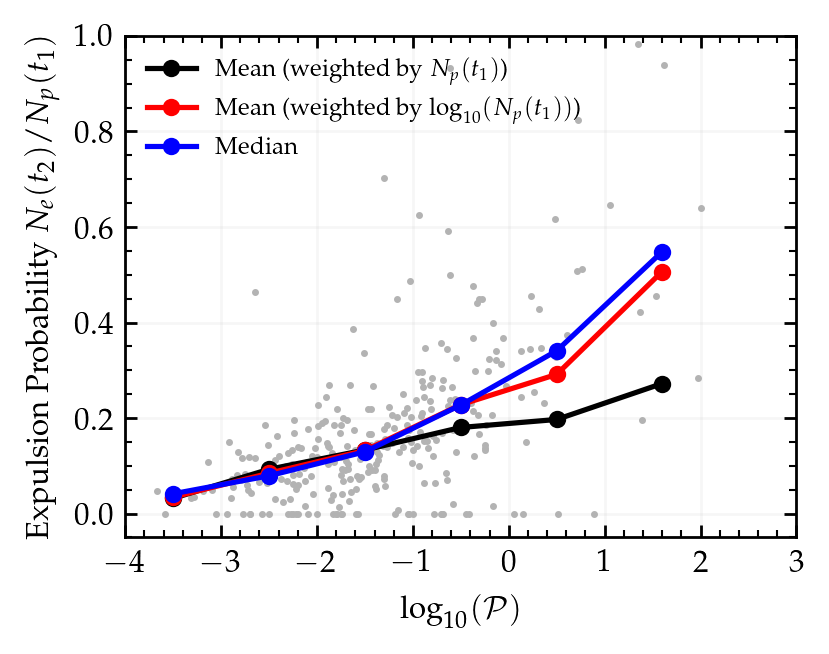

In [522]:
fig, ax = plt.subplots(1,1,dpi=250, figsize=(3.2,2.5), constrained_layout=True)

ax.scatter(np.log10(ratios), E_prob, c='0.7', s=1)
ax.plot(bc, E_prob_weighted, 'ko-', ms=4, label=r'Mean (weighted by $N_p(t_1)$)')
ax.plot(bc, E_prob_weighted_log, 'ro-', ms=4, label=r'Mean (weighted by $\log_{10}(N_p(t_1))$)')
ax.plot(bc, E_prob_median, 'bo-', ms=4, label='Median')

ax.legend(frameon=False, fontsize=7)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'Expulsion Probability $N_{e}(t_2)/N_{p}(t_1)$')
ax.set_xlim(-4, 3)
ax.set_ylim(-0.05, 1)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

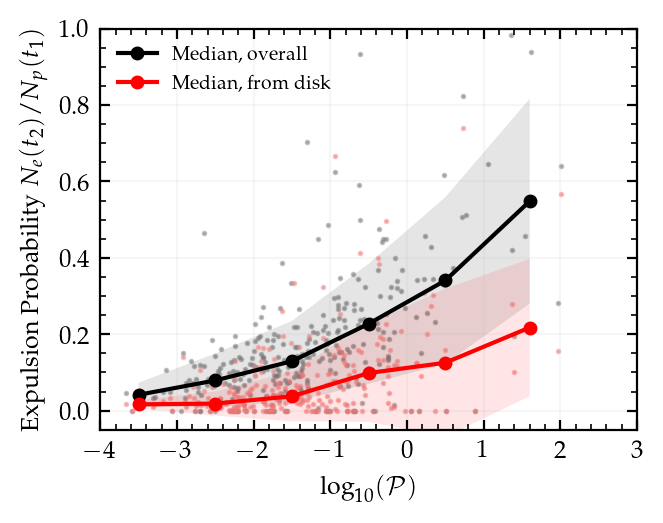

In [486]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.2,2.5), constrained_layout=True)

ax.scatter(np.log10(ratios), E_prob, c='0.5', s=1, alpha=0.5)
ax.fill_between(bc, E_prob_median-std, E_prob_median+std, color='k', ec=None, alpha=0.1)
ax.plot(bc, E_prob_median, 'ko-', ms=4, label=r'Median, overall')

ax.scatter(np.log10(ratios_disk), E_prob_disk, c='lightcoral', s=1, alpha=0.5)
ax.fill_between(bc, E_prob_median_disk-std_disk, E_prob_median_disk+std_disk, color='r', ec=None, alpha=0.1)
ax.plot(bc, E_prob_median_disk, 'ro-', ms=4, label=r'Median, from disk')

ax.legend(frameon=False, fontsize=7)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'Expulsion Probability $N_{e}(t_2)/N_{p}(t_1)$')
ax.set_xlim(-4, 3)
ax.set_ylim(-0.05, 1)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

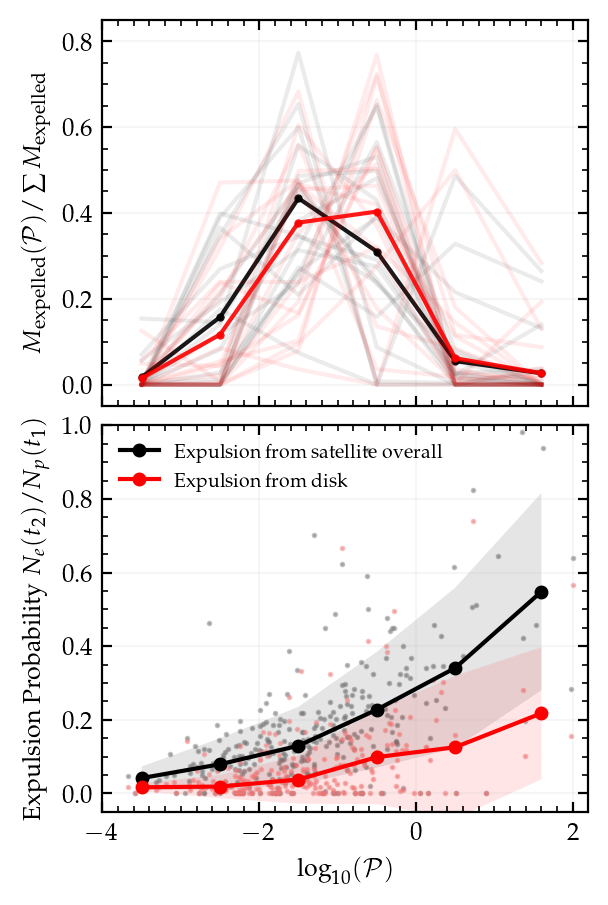

In [599]:
bins_main = np.append(np.arange(-4,2,1),2.2)

fig, ax = plt.subplots(2,1,dpi=200, figsize=(3,4.5), sharex=True)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = np.log10(d.ratio)
    y = d.M_expelled
    cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
    BigSum = np.sum(y[cond])
    Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins_main)
    bc = 0.5*(bins[1:]+bins[:-1])
    ax[0].plot(bc, Sum/BigSum, 'k-', ms=2, alpha=0.08)

x = np.log10(data_all.ratio)
y = data_all.M_expelled
cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
BigSum = np.sum(y[cond])
Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins_main)
bc = 0.5*(bins[1:]+bins[:-1])
im = ax[0].plot(bc, Sum/BigSum, 'ko-', ms=2, alpha=0.9)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = np.log10(d.ratio)
    y = d.M_expelled_disk
    cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
    BigSum = np.sum(y[cond])
    Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins_main)
    bc = 0.5*(bins[1:]+bins[:-1])
    ax[0].plot(bc, Sum/BigSum, 'r-', ms=2, alpha=0.08)

x = np.log10(data_all.ratio)
y = data_all.M_expelled_disk
cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
BigSum = np.sum(y[cond])
Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins_main)
bc = 0.5*(bins[1:]+bins[:-1])
im = ax[0].plot(bc, Sum/BigSum, 'ro-', ms=2, alpha=0.9)
    
ax[0].set_ylabel(r'$M_{\rm expelled}(\mathcal{P})/\sum M_{\rm expelled}$')
ax[0].set_xlim(-4, 2.2)
ax[0].set_ylim(-0.05, 0.85)
ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].grid(alpha=0.1, zorder=-1000)

bins = bins_main
bc = 0.5*(bins[1:] + bins[:-1])
E_prob_median, E_prob_weighted, E_prob_weighted_log, std = np.array([]),np.array([]),np.array([]),np.array([])
E_prob_median_disk, E_prob_weighted_disk, E_prob_weighted_log_disk, std_disk = np.array([]),np.array([]),np.array([]),np.array([])
for left_edge, right_edge in zip(bins[:-1],bins[1:]):
    cond = (np.log10(ratios) >= left_edge) & (np.log10(ratios) < right_edge)
    E_prob_weighted = np.append(E_prob_weighted,np.average(E_prob[cond], weights=N_p[cond]))
    E_prob_weighted_log = np.append(E_prob_weighted_log,np.average(E_prob[cond], weights=np.log10(N_p)[cond]))
    E_prob_median = np.append(E_prob_median,np.median(E_prob[cond]))
    std = np.append(std, np.std(E_prob[cond]))
    
    cond = (np.log10(ratios_disk) >= left_edge) & (np.log10(ratios_disk) < right_edge)
    E_prob_weighted_disk = np.append(E_prob_weighted_disk,np.average(E_prob_disk[cond], weights=N_p_disk[cond]))
    E_prob_weighted_log_disk = np.append(E_prob_weighted_log_disk,np.average(E_prob_disk[cond], weights=np.log10(N_p_disk)[cond]))
    E_prob_median_disk = np.append(E_prob_median_disk,np.median(E_prob_disk[cond]))
    std_disk = np.append(std_disk, np.std(E_prob_disk[cond]))
    

ax[1].scatter(np.log10(ratios), E_prob, c='0.5', s=1, alpha=0.5)
ax[1].fill_between(bc, E_prob_median-std, E_prob_median+std, color='k', ec=None, alpha=0.1)
ax[1].plot(bc, E_prob_median, 'ko-', ms=4, label=r'Expulsion from satellite overall')

ax[1].scatter(np.log10(ratios_disk), E_prob_disk, c='lightcoral', s=1, alpha=0.5)
ax[1].fill_between(bc, E_prob_median_disk-std_disk, E_prob_median_disk+std_disk, color='r', ec=None, alpha=0.1)
ax[1].plot(bc, E_prob_median_disk, 'ro-', ms=4, label=r'Expulsion from disk')

ax[1].legend(frameon=False, fontsize=7)
ax[1].set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax[1].set_ylabel(r'Expulsion Probability $N_{e}(t_2)/N_{p}(t_1)$')
ax[1].set_xlim(-4, 2.2)
ax[1].set_ylim(-0.05, 1)
ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].grid(alpha=0.1, zorder=-1000)

plt.subplots_adjust(hspace=0.05, top=0.98, right=0.98, bottom=0.1, left=0.17)
plt.savefig('plots/expulsion_prob_by_Pram.pdf')
plt.show()

We see increasing expulsion probablity with increasing ram pressure ratio, as expected. But can we combine this with the histogram to get back out the fraction of mass expelled at different ram pressure ratios?

We calculate this as $N_{\rm snap}(\mathcal{P}) \times P_{\rm expelled}(\mathcal{P}) / \sum N_{\rm snap}\times P_{\rm expelled}$

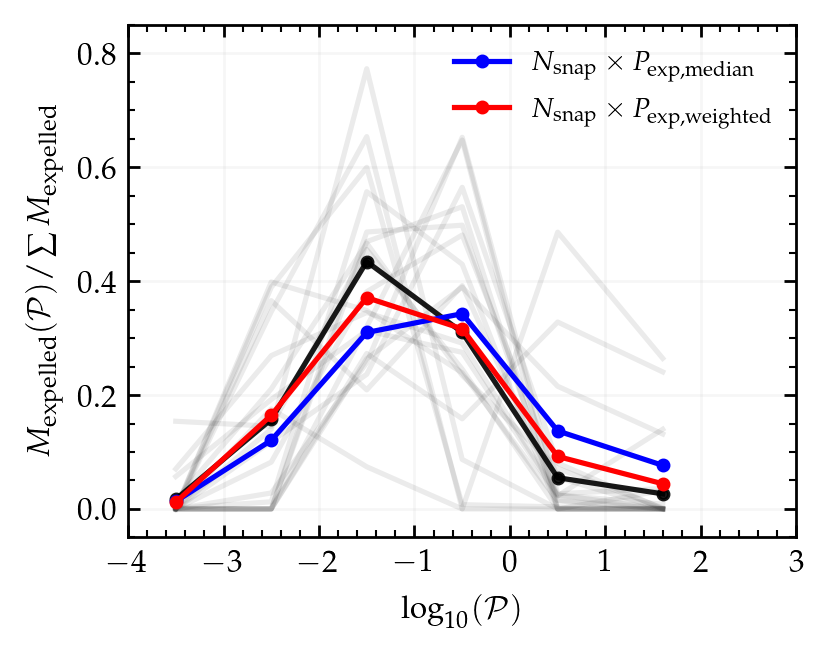

In [521]:
fig, ax = plt.subplots(1,1,dpi=250, figsize=(3.2,2.5), constrained_layout=True)
bins = np.append(np.arange(-4, 2, 1),2.2)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = np.log10(d.ratio)
    y = d.M_expelled
    cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
    BigSum = np.sum(y[cond])
    Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins)
    bc = 0.5*(bins[1:]+bins[:-1])
    ax.plot(bc, Sum/BigSum, 'k-', ms=2, alpha=0.08)

x = np.log10(data_all.ratio)
y = data_all.M_expelled
cond = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
BigSum = np.sum(y[cond])
Sum, bins, binnumber = scipy.stats.binned_statistic(x[cond], y[cond], statistic='sum', bins=bins)
bc = 0.5*(bins[1:]+bins[:-1])
im = ax.plot(bc, Sum/BigSum, 'ko-', ms=3, alpha=0.9)

N, bins = np.histogram(np.log10(data_all.ratio), bins=bins, density=True)
plt.plot(bc, N*E_prob_median/(np.sum(N*E_prob_median)), 'bo-', ms=3, label=r'$N_{\rm snap}\times P_{\rm exp,median}$')
plt.plot(bc, N*E_prob_weighted/(np.sum(N*E_prob_weighted)), 'ro-', ms=3, label=r'$N_{\rm snap}\times P_{\rm exp,weighted}$')

ax.legend(frameon=False, fontsize=8)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'$M_{\rm expelled}(\mathcal{P})/\sum M_{\rm expelled}$')
ax.set_xlim(-4, 3)
ax.set_ylim(-0.05, 0.85)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

# plt.savefig('plots/fraction_expelled_by_Pram.pdf')
plt.show()

We see that we can pretty neatly back out the fraction of gas mass expelled at each ram pressure ratio. We do a bit better when we use the probability weighted by the number of particles (i.e. $N_p(t_1)$), as this takes into account the fact that satellites have more material available to be expelled when they are at lower ram pressure ratios. 

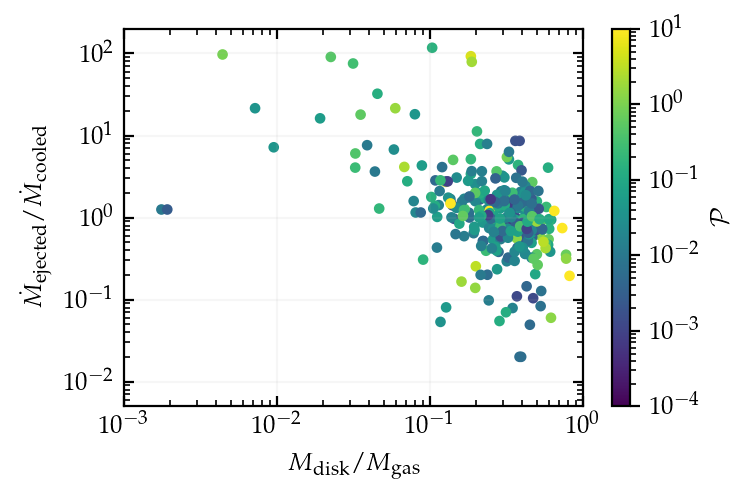

In [108]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

norm = mpl.colors.LogNorm(vmin=1e-4, vmax=1e1)
x = np.array(data_all.M_disk/data_all.M_gas,dtype=float)
y = np.array(data_all.Mdot_ejected/data_all.Mdot_cooled,dtype=float)
im = ax.scatter(x, y, s=8, c=data_all.ratio, norm=norm)

fig.colorbar(im, ax=ax, label=r'$\mathcal{P}$')
ax.set_xlabel(r'$M_{\rm disk}/M_{\rm gas}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm ejected}/\dot{M}_{\rm cooled}$')
ax.loglog()
ax.set_xlim(1e-3,1e0)
ax.set_ylim(5e-3, 2e2)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

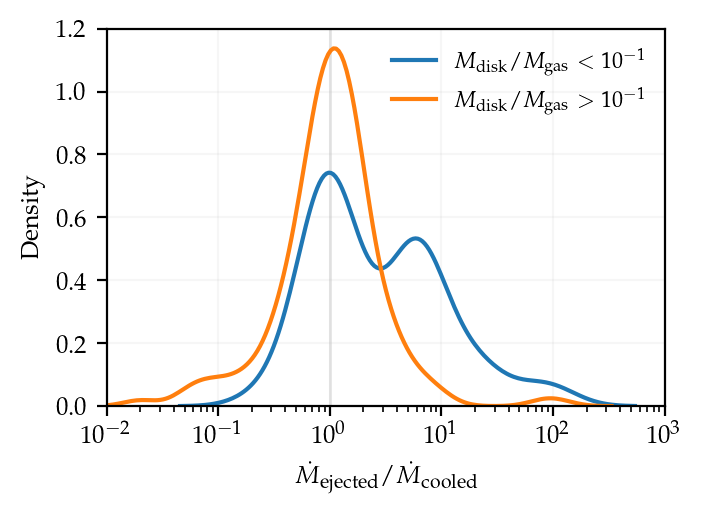

In [109]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.6,2.5), sharey=True)

x = np.array(data_all.Mdot_ejected/data_all.Mdot_cooled, dtype=float)
c = np.array(data_all.M_disk/data_all.M_gas, dtype=float)
data_all['diskFractionCat'] = pd.cut(data_all.diskFraction, bins=[1e-3, 1e-1, 1e0], labels=[r'$M_{\rm disk}/M_{\rm gas} < 10^{-2}$', r'$M_{\rm disk}/M_{\rm gas} \geq 10^{-1}$'])

import seaborn as sns
sns.kdeplot(x[c < 1e-1], ax=ax, log_scale=True, label=r'$M_{\rm disk}/M_{\rm gas} < 10^{-1}$')
sns.kdeplot(x[c >= 1e-1], ax=ax, log_scale=True, label=r'$M_{\rm disk}/M_{\rm gas} > 10^{-1}$')


ax.set_xlim(1e-2, 1e3)
ax.set_xlabel(r'$\dot{M}_{\rm ejected}/\dot{M}_{\rm cooled}$')
ax.legend(frameon=False, loc='upper right', fontsize=8)
ax.plot([1,1],[0,2], color='0.9', linestyle='-', linewidth=1, zorder=-100)
ax.grid(alpha=0.1, zorder=-1000)
ax.set_ylim(0, 1.2)

plt.show()

## What does the above plot tell us? 

When the fraction of the satellite gas mass this is in the disk is large ($M_{\rm disk}/M_{\rm gas} > 10^{-1}$), we typically see even amounts of cooling and ejection, maybe even a bit more cooling. This reflects the standard baryon cycle of gas between the disk and the halo: SNe feedback ejects gas, which eventually cools back onto the disk. 

However, when the fraction of the satellite gas mass that is in the disk is small ($10^{-2} < M_{\rm disk}/M_{\rm gas} < 10^{-1}$), we universally see net ejection of gas (in some cases by a factor of 100). 
I'm not yet sure what this means. 
- There isn't a disk to go back to? 
- Channels for cooling are blocked somehow? 
- Restoring force is so low that gas is stripped before it can cool? 

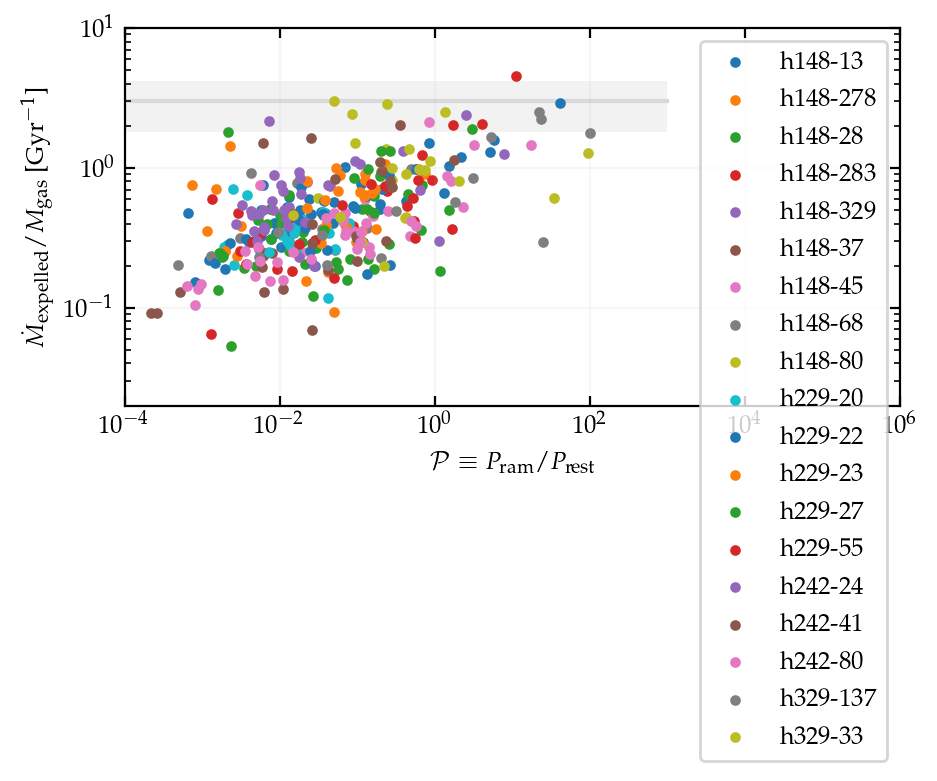

In [254]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(5,2.5))

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    im = ax.scatter(d.ratio, d.Mdot_expelled_by_Mgas, s=8, label=key.replace('_','-'))
    
ax.legend()
# fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$\dot{M}_{\rm expelled}/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 1e6)
ax.set_ylim(2e-2, 1e1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

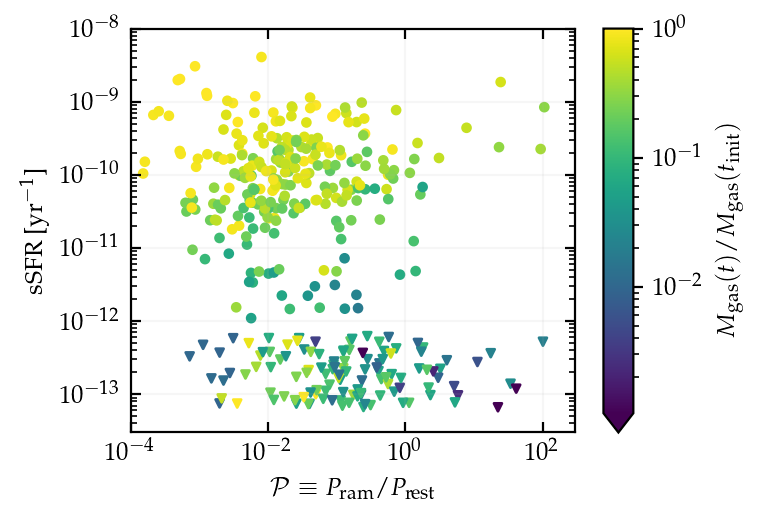

In [358]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5), constrained_layout=True)

sSFR = np.array(data_all.sSFR,dtype=float)
im = ax.scatter(data_all.ratio, sSFR, s=8, c=data_all.f_gas, norm=mpl.colors.LogNorm(vmax=1.1, vmin=1.05e-3))

im = ax.scatter(data_all.ratio[sSFR==0], 10**np.random.uniform(low=-13.2, high=-12.2, size=len(sSFR[sSFR==0])), s=8, 
                c=data_all.f_gas[sSFR==0], norm=mpl.colors.LogNorm(vmax=1, vmin=1.05e-3), marker='v')

fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'sSFR [yr$^{-1}$]')
ax.loglog()
ax.set_xlim(1e-4, 3e2)
ax.set_ylim(3e-14, 1e-8)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
# ax.annotate('h148-68 (at first \n pericentric passage)', (2e1, 2e-9), ha='right', fontsize=6)


# plt.subplots_adjust(left=0.15, top=0.96, right=0.93, bottom=0.15, hspace=0.05)
plt.savefig('plots/Pram_sSFR.pdf')
plt.show()

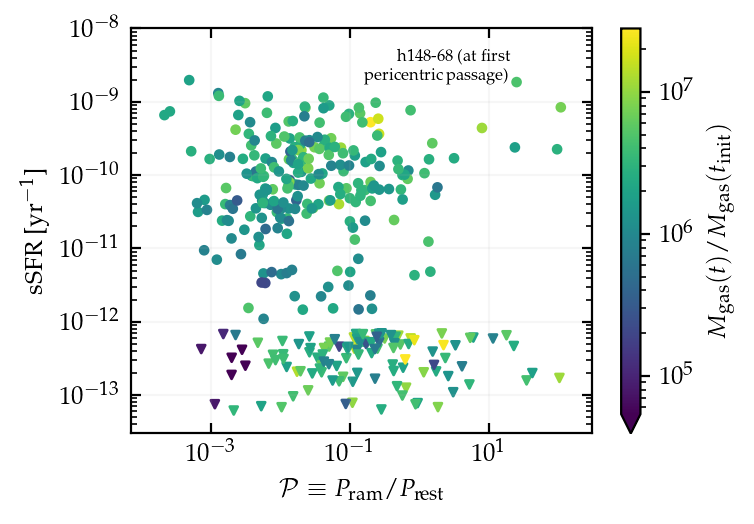

In [344]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

sSFR = np.array(data_all.sSFR,dtype=float)
im = ax.scatter(data_all.ratio, sSFR, s=8, c=data_all.M_expelled, norm=mpl.colors.LogNorm())

im = ax.scatter(data_all.ratio[sSFR==0], np.random.uniform(low=5e-14, high=7e-13, size=len(sSFR[sSFR==0])), s=8, 
                c=data_all.M_expelled[sSFR==0], norm=mpl.colors.LogNorm(), marker='v')

fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}(t)/M_{\rm gas}(t_{\rm init})$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'sSFR [yr$^{-1}$]')
ax.loglog()
ax.set_xlim(7e-5, 3e2)
ax.set_ylim(3e-14, 1e-8)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)
ax.annotate('h148-68 (at first \n pericentric passage)', (2e1, 2e-9), ha='right', fontsize=6)


plt.subplots_adjust(left=0.15, top=0.96, right=0.93, bottom=0.15, hspace=0.05)
# plt.savefig('plots/Pram_ejection.pdf')
plt.show()

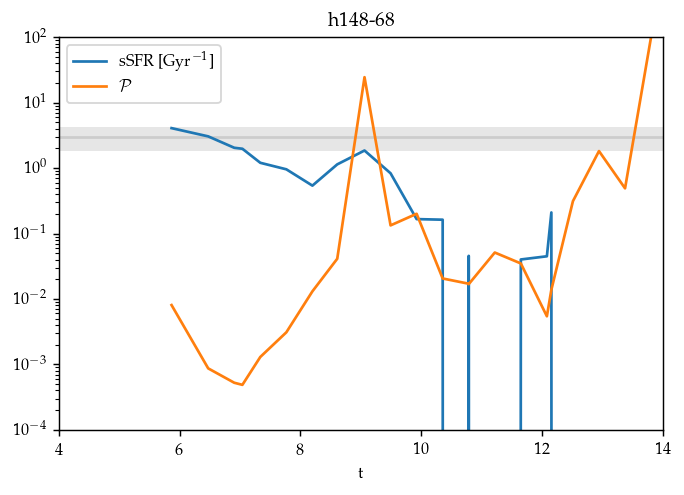

In [142]:
for key in np.unique(data_all.key):
    if not key=='h148_68': continue;
    data = data_all[data_all.key==key]
    plt.figure(dpi=130)
    plt.plot(data.t, data.sSFR*1e9, label=r'sSFR [Gyr$^{-1}$]')
    plt.plot(data.t, data.ratio, label=r'$\mathcal{P}$')
    plt.title(key.replace('_','-'))
    plt.xlabel('t')
    plt.xlim(4, 14)
    plt.ylim(1e-4, 1e2)
    plt.plot([4,14],[3,3],color='0.8', zorder=-90)
    plt.fill_between([4,14],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.9', zorder=-100)
    plt.semilogy()
    plt.legend()
    plt.show()

$$P_{\rm rest} = \Sigma_{\rm gas} \bigg|\frac{d\Phi}{dz}\bigg|_{\rm max} \approx \left(\frac{M_{\rm gas}}{2\pi r_{\rm half}^2}\right)\left(\frac{v_{\rm max}^2}{r_{\rm max}}\right)$$

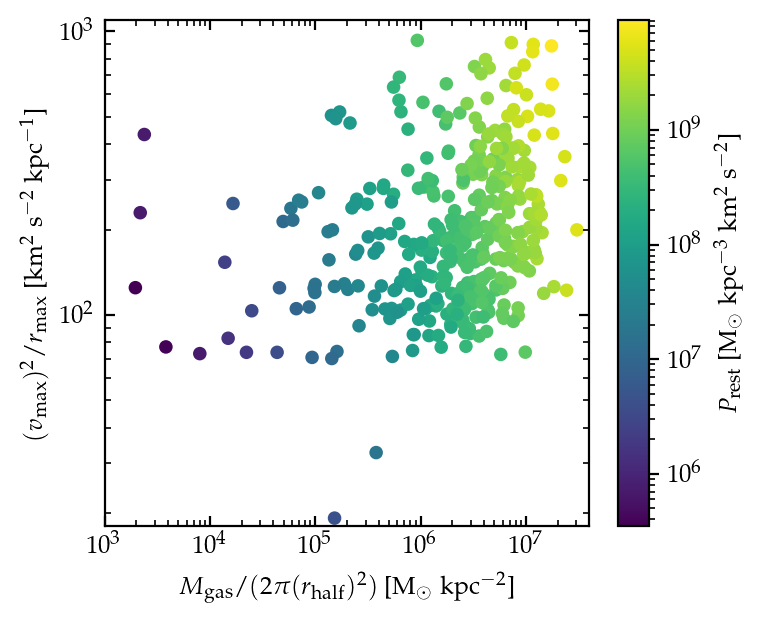

In [526]:
plt.figure(dpi=200, figsize=(3.7,3), constrained_layout=True)

dphidz = data_all.dphidz
dphidz /= data_all.a
dphidz *= 0.67

plt.scatter(data_all.SigmaGas, dphidz, s=15, c=data_all.Prest, norm=mpl.colors.LogNorm())
plt.colorbar(label=r'$P_{\rm rest}$ [M$_{\odot}$ kpc$^{-3}$ km$^2$ s$^{-2}$]')
plt.loglog()
plt.ylim(1.8e1, 1.1e3)
plt.xlim(1e3, 4e7)
plt.xlabel(r'$M_{\rm gas}/(2\pi (r_{\rm half})^2)$ [M$_{\odot}$ kpc$^{-2}$]')
plt.ylabel(r'$(v_{\rm max})^2 /r_{\rm max}$ [km$^{2}$ s$^{-2}$ kpc$^{-1}$]')
plt.tick_params(direction='in', which='both', top=True, right=True)

# plt.savefig('plots/Prest_decomp.pdf')
plt.show()

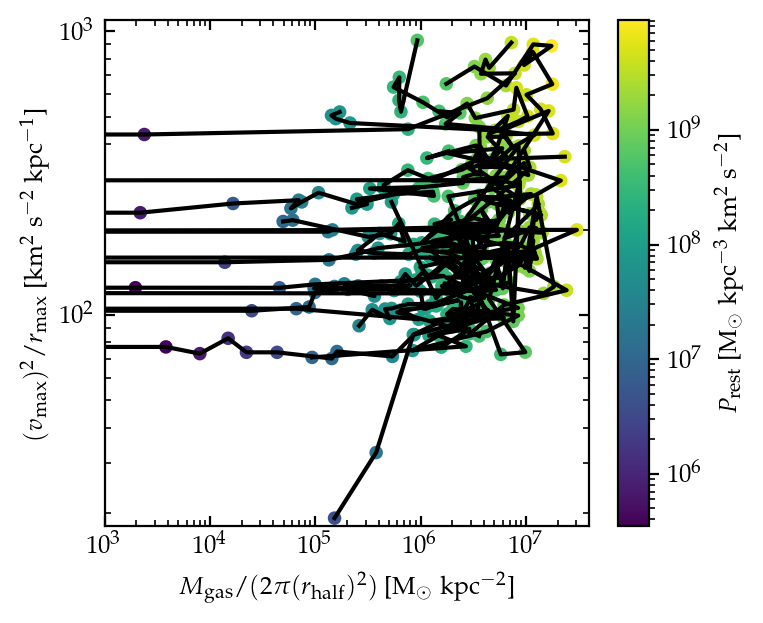

In [528]:
plt.figure(dpi=200, figsize=(3.7,3), constrained_layout=True)

dphidz = data_all.dphidz
dphidz /= data_all.a
dphidz *= 0.67

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    plt.plot(d.SigmaGas, dphidz[data_all.key==key], color='k')


plt.scatter(data_all.SigmaGas, dphidz, s=15, c=data_all.Prest, norm=mpl.colors.LogNorm())
plt.colorbar(label=r'$P_{\rm rest}$ [M$_{\odot}$ kpc$^{-3}$ km$^2$ s$^{-2}$]')
plt.loglog()
plt.ylim(1.8e1, 1.1e3)
plt.xlim(1e3, 4e7)
plt.xlabel(r'$M_{\rm gas}/(2\pi (r_{\rm half})^2)$ [M$_{\odot}$ kpc$^{-2}$]')
plt.ylabel(r'$(v_{\rm max})^2 /r_{\rm max}$ [km$^{2}$ s$^{-2}$ kpc$^{-1}$]')
plt.tick_params(direction='in', which='both', top=True, right=True)

# plt.savefig('plots/Prest_decomp.pdf')
plt.show()

In [100]:
def get_halo_masses(d):
    sim = str(d.key)[:4]
    haloid = int(str(d.key)[5:])
    t = float(d.t)
    ts = read_timesteps(sim)
    ts = ts[ts.z0haloid==haloid]
    times = np.array(ts.time, dtype=float)
    M_halos = np.array(ts.mass-ts.mgas-ts.mstar, dtype=float)
    M_halo = M_halos[np.argmin(np.abs(times-t))]
    d['M_halo'] = M_halo
    d['M_halo_peak'] = np.max(M_halos)
    d['M_gas_peak'] = np.max(ts.mgas)
    return d
    
from tqdm import tqdm
tqdm.pandas()
data_all = data_all.progress_apply(get_halo_masses, axis=1)

/Users/hollis/anaconda3/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 298/298 [05:03<00:00,  1.02s/it]


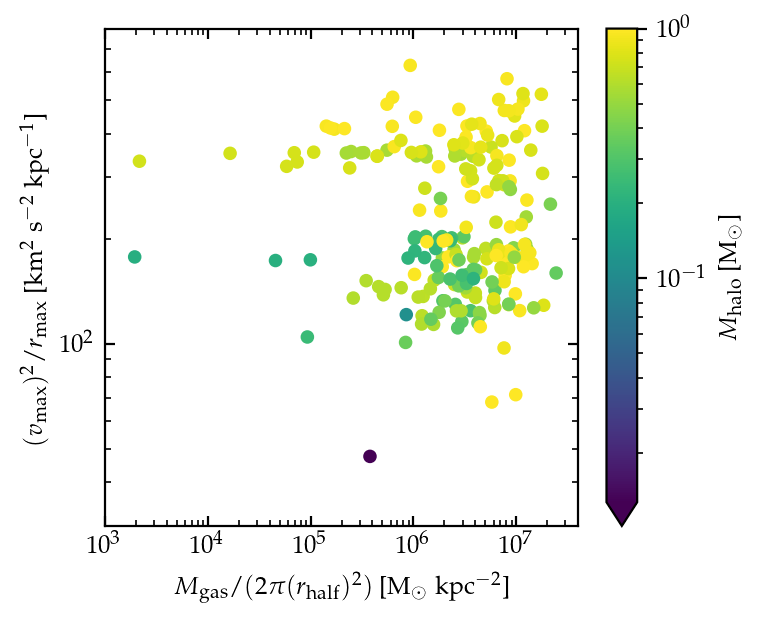

In [803]:
plt.figure(dpi=200, figsize=(3.7,3), constrained_layout=True)

dphidz = data_all.dphidz
dphidz /= data_all.a
dphidz *= 0.67

plt.scatter(data_all.SigmaGas, dphidz, s=15, c=data_all.M_halo/data_all.M_halo_peak, norm=mpl.colors.LogNorm())
plt.colorbar(label=r'$M_{\rm halo}$ [M$_{\odot}$]', extend='min')
plt.loglog()
plt.ylim(3e1, 8e2)
plt.xlim(1e3, 4e7)
plt.xlabel(r'$M_{\rm gas}/(2\pi (r_{\rm half})^2)$ [M$_{\odot}$ kpc$^{-2}$]')
plt.ylabel(r'$(v_{\rm max})^2 /r_{\rm max}$ [km$^{2}$ s$^{-2}$ kpc$^{-1}$]')
plt.tick_params(direction='in', which='both', top=True, right=True)

# plt.savefig('plots/Prest_decomp.pdf')
plt.show()

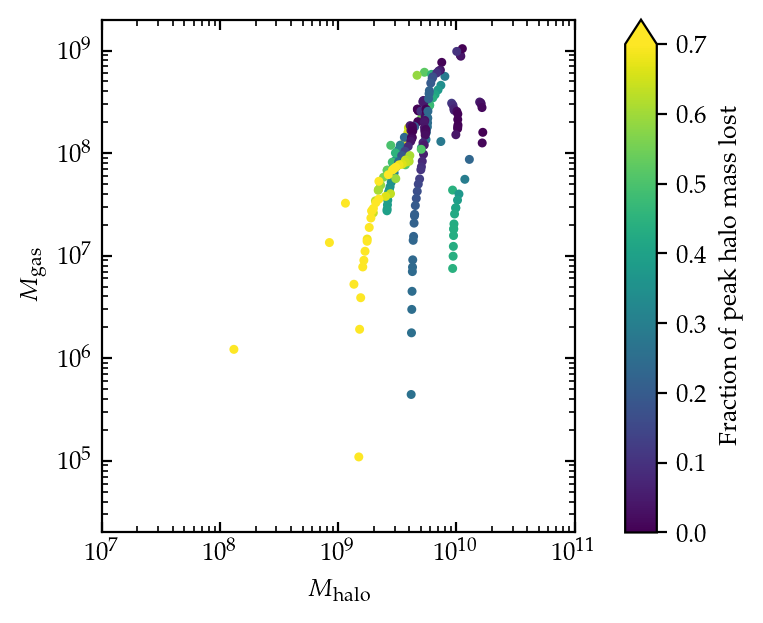

In [816]:
plt.figure(dpi=200, figsize=(3.7,3), constrained_layout=True)

plt.scatter(data_all.M_halo, data_all.M_gas, s=5, c=1-(data_all.M_halo/data_all.M_halo_peak), vmax=0.7)#, norm=mpl.colors.LogNorm())
plt.colorbar(label=r'Fraction of peak halo mass lost', extend='max')
plt.loglog()
plt.ylim(2e4, 2e9)
plt.xlim(1e7, 1e11)
plt.xlabel(r'$M_{\rm halo}$')
plt.ylabel(r'$M_{\rm gas}$')
plt.tick_params(direction='in', which='both', top=True, right=True)

plt.show()

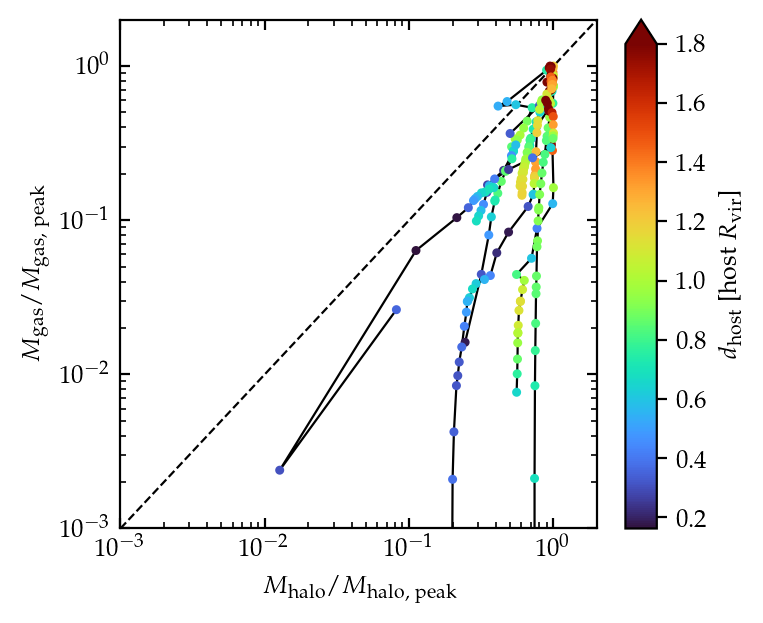

In [851]:
plt.figure(dpi=200, figsize=(3.7,3), constrained_layout=True)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    d = d.sort_values('t')
    plt.plot(d.M_halo/d.M_halo_peak, d.M_gas/d.M_gas_peak, color='k', linewidth=0.8)

plt.scatter(data_all.M_halo/data_all.M_halo_peak, data_all.M_gas/data_all.M_gas_peak, s=5, 
            c=data_all.h1dist/data_all.hostRvir, vmax=1.8, cmap='turbo', zorder=1000)
plt.colorbar(label=r'$d_{\rm host}$ [host $R_{\rm vir}$]', extend='max')
plt.loglog()
plt.ylim(1e-3, 2)
plt.xlim(1e-3, 2)
plt.xlabel(r'$M_{\rm halo}/M_{\rm halo,~peak}$')
plt.ylabel(r'$M_{\rm gas}/M_{\rm gas,~peak}$')
plt.plot([1e-3, 1e1], [1e-3, 1e1], c='k', linestyle='--', linewidth=0.8, zorder=-1000)
plt.tick_params(direction='in', which='both', top=True, right=True)

plt.show()

In [272]:
from tqdm import tqdm
timescales = read_timescales()
timescales = timescales[(timescales.quenched==True)&(~np.isnan(timescales.tinfall))]
tau = timescales.tinfall - timescales.tquench

r_peris, keys, z0_halo_fracs, tq_halo_fracs = np.array([]), np.array([]), np.array([]), np.array([])
for t in tqdm(timescales.iterrows(), total=len(timescales)):
    t = t[1]
    sim = t.sim
    haloid = t.haloid
    key = sim + '_' + str(int(haloid))
    
    ts = read_timesteps(sim)
    ts = ts[ts.z0haloid==haloid]
    ts = ts.sort_values('t')
    
    tq = age - t.tquench
    
    r_peri = np.min(ts.h1dist)
    
    M_halos = np.array(ts.mass-ts.mstar-ts.mgas,dtype=float)
    z0_halo_frac = M_halos[-1]/np.max(M_halos)
    tq_halo_frac = M_halos[np.argmin(np.abs(ts.t-tq))]/np.max(M_halos)
    
    r_peris = np.append(r_peris, r_peri)
    z0_halo_fracs = np.append(z0_halo_fracs, z0_halo_frac)
    tq_halo_fracs = np.append(tq_halo_fracs, tq_halo_frac)
    keys= np.append(keys, key)
    

100%|██████████| 71/71 [01:30<00:00,  1.27s/it]


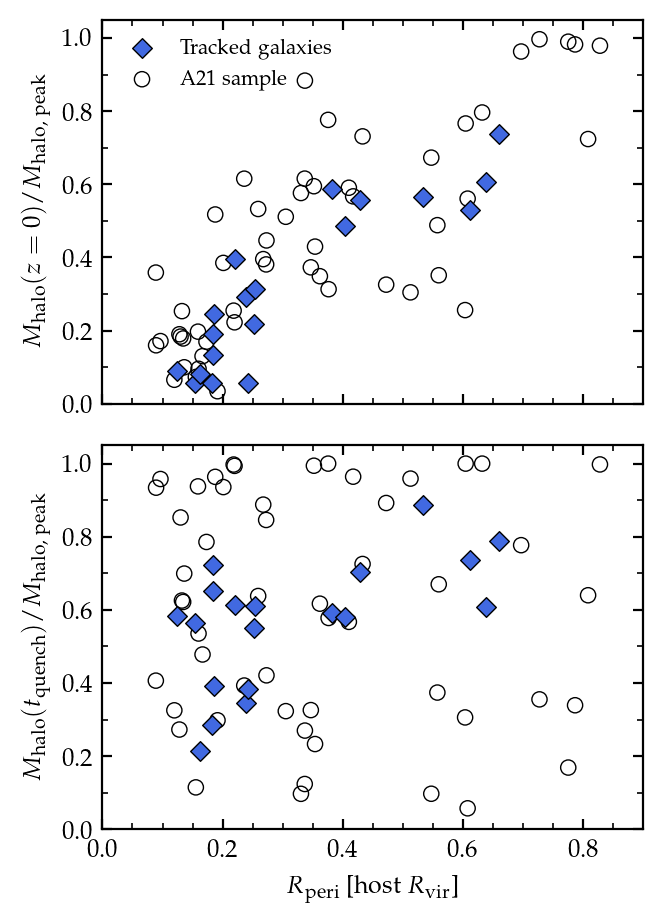

In [280]:
fig, ax = plt.subplots(2,1,figsize=(3.2, 4.5), dpi=200, constrained_layout=True, sharex=True)

cond = np.array([k in np.unique(data_all.key) for k in keys])
ax[0].scatter([100,100], [100,100], s=25, marker='D', fc='royalblue', ec='k', linewidths=0.5, label='Tracked galaxies')
ax[0].scatter(r_peris[~cond], z0_halo_fracs[~cond], s=30, ec='k', fc='none', linewidths=0.5, label='A21 sample')
ax[0].scatter(r_peris[cond], z0_halo_fracs[cond], s=25, marker='D',fc='royalblue', ec='k', linewidths=0.5)

ax[0].legend(frameon=False, loc='upper left', fontsize=7.5)
ax[0].set_ylabel(r'$M_{\rm halo}(z=0)/M_{\rm halo,~peak}$')

ax[1].scatter(r_peris[~cond], tq_halo_fracs[~cond], s=30, ec='k', fc='none', linewidths=0.5)
ax[1].scatter(r_peris[cond], tq_halo_fracs[cond], s=25, marker='D',fc='royalblue', ec='k', linewidths=0.5)

ax[1].set_ylabel(r'$M_{\rm halo}(t_{\rm quench})/M_{\rm halo,~peak}$')
ax[1].set_xlabel(r'$R_{\rm peri}$ [host $R_{\rm vir}$]')


for a in ax:
    a.set_xlim(0, 0.9)
    a.set_ylim(0,1.05)
    a.tick_params(direction='in', which='both', top=True, right=True)
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.savefig('plots/Mhalo_Rperi.pdf')
plt.show()

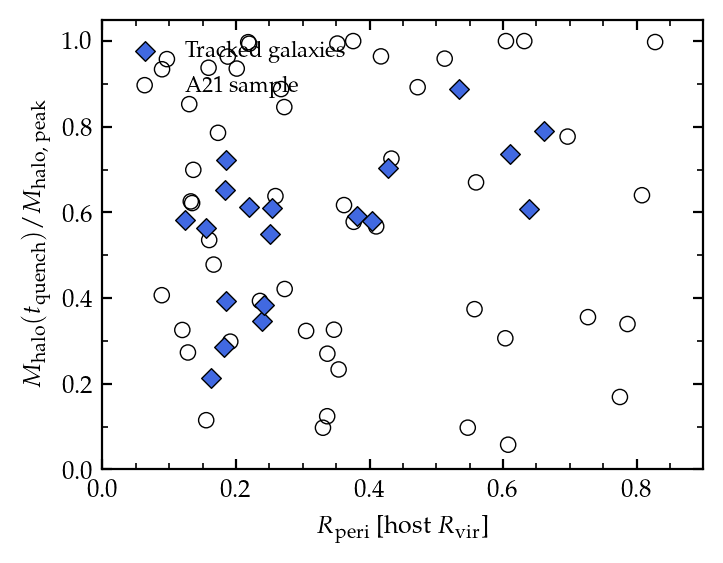

In [275]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 2.7), dpi=200, constrained_layout=True)

cond = np.array([k in np.unique(data_all.key) for k in keys])
ax.scatter([100,100], [100,100], s=25, marker='D', fc='royalblue', ec='k', linewidths=0.5, label='Tracked galaxies')
ax.scatter(r_peris[~cond], tq_halo_fracs[~cond], s=30, ec='k', fc='none', linewidths=0.5, label='A21 sample')
ax.scatter(r_peris[cond], tq_halo_fracs[cond], s=25, marker='D',fc='royalblue', ec='k', linewidths=0.5)



ax.legend(frameon=False, loc='upper left', fontsize=8)
ax.set_xlim(0, 0.9)
ax.set_ylim(0,1.05)
ax.set_xlabel(r'$R_{\rm peri}$ [host $R_{\rm vir}$]')
ax.set_ylabel(r'$M_{\rm halo}(t_{\rm quench})/M_{\rm halo,~peak}$')

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

# plt.savefig('plots/Mhalo_Rperi.pdf')
plt.show()

In [406]:
len(z0_halo_fracs)

71

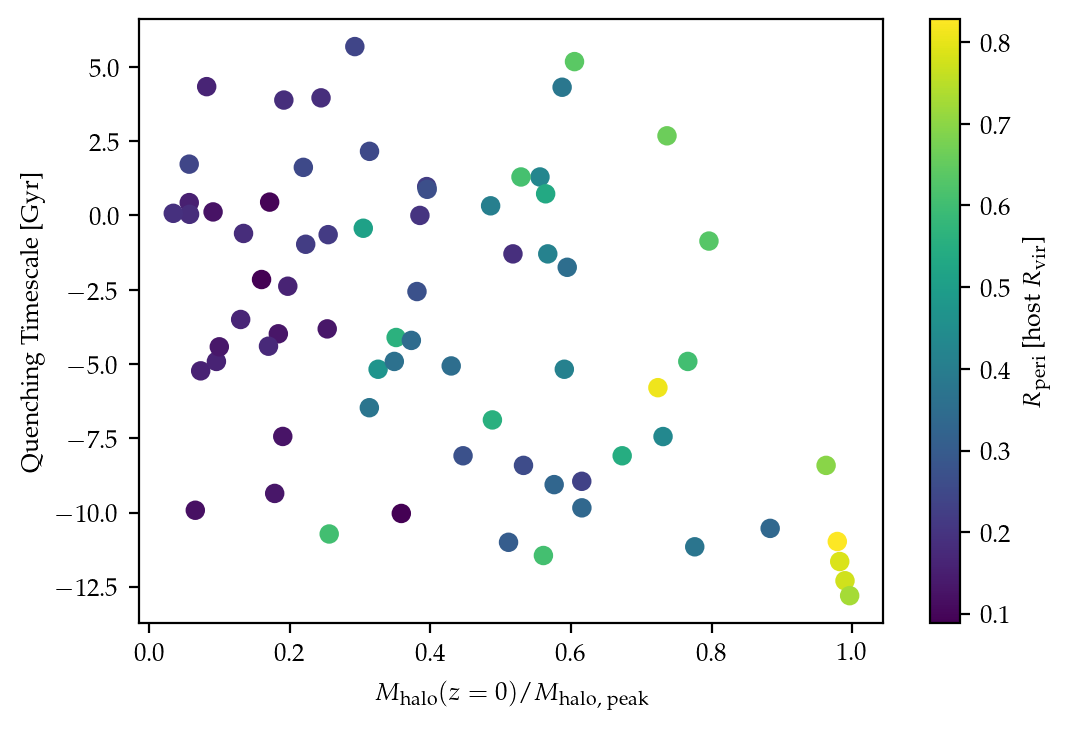

In [75]:
plt.figure(dpi=200)
plt.scatter(z0_halo_fracs, , c=r_peris)
plt.ylabel('Quenching Timescale [Gyr]')
plt.xlabel(r'$M_{\rm halo}(z=0)/M_{\rm halo,~peak}$')
plt.colorbar(label=r'$R_{\rm peri}$ [host $R_{\rm vir}$]')
plt.show()

In [839]:
np.array(data_all.key,dtype=str)[np.argmin(data_all.M_halo/data_all.M_halo_peak)]

'h242_80'

In [817]:
data_all.keys()

Index(['t', 'a', 'h1dist', 'M_star', 'M_gas', 'satRvir', 'hostRvir', 'vel_CGM',
       'rho_CGM', 'Pram', 'n_CGM', 'vel_CGM_adv', 'rho_CGM_adv', 'Pram_adv',
       'Prest', 'SigmaGas', 'dphidz', 'ratio', 'dt', 'tau', 'time_x',
       'M_ejected', 'Mdot_ejected', 'Mdot_ejected_by_Mgas', 'time_y',
       'M_cooled', 'Mdot_cooled', 'Mdot_cooled_by_Mgas', 'time_x',
       'M_expelled', 'Mdot_expelled', 'Mdot_expelled_by_Mgas', 'time_y',
       'M_accreted', 'Mdot_accreted', 'Mdot_accreted_by_Mgas', 'key', 'f_gas',
       'M_halo', 'M_halo_peak', 'M_gas_peak'],
      dtype='object')

(0.0, 3.0)

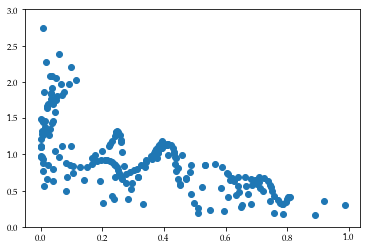

In [820]:
plt.scatter(1-(data_all.M_halo/data_all.M_halo_peak), data_all.h1dist/data_all.hostRvir)
plt.ylim(0,3)

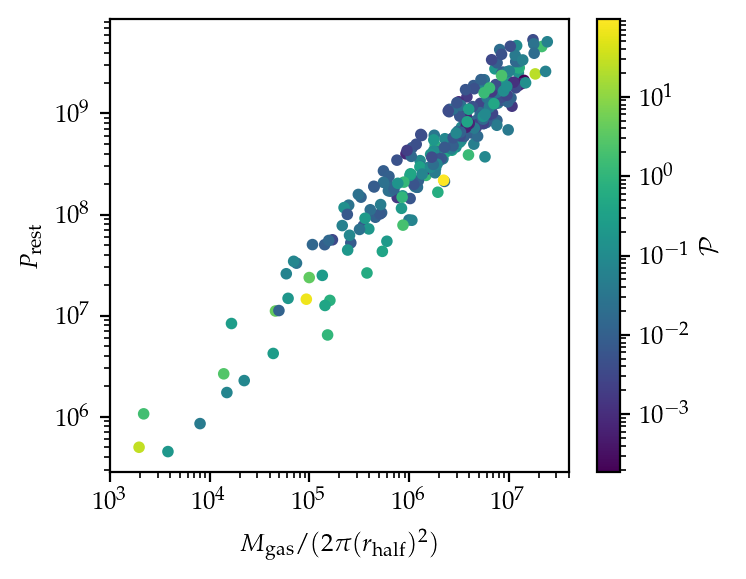

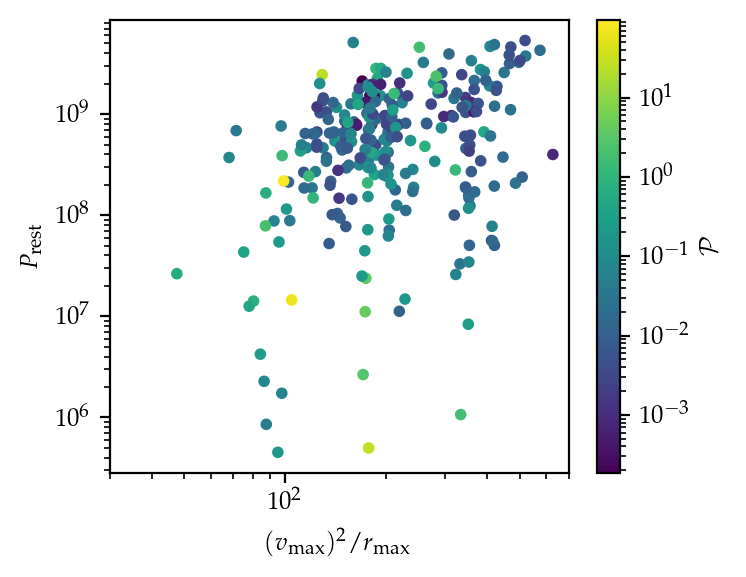

In [76]:
dphidz = data_all.dphidz
dphidz /= data_all.a
dphidz *= 0.67

plt.figure(dpi=200, figsize=(3.7,3))
plt.scatter(data_all.SigmaGas, data_all.Prest, s=10, c=data_all.ratio, norm=mpl.colors.LogNorm())
plt.colorbar(label=r'$\mathcal{P}$')
plt.loglog()
# plt.ylim(3e1, 7e2)
plt.xlim(1e3, 4e7)
plt.xlabel(r'$M_{\rm gas}/(2\pi (r_{\rm half})^2)$')
plt.ylabel(r'$P_{\rm rest}$')
plt.show()

plt.figure(dpi=200, figsize=(3.7,3))
plt.scatter(dphidz, data_all.Prest, s=10, c=data_all.ratio, norm=mpl.colors.LogNorm())
plt.colorbar(label=r'$\mathcal{P}$')
plt.loglog()
plt.xlim(3e1, 7e2)
plt.xlabel(r'$(v_{\rm max})^2 /r_{\rm max}$')
plt.ylabel(r'$P_{\rm rest}$')
plt.show()

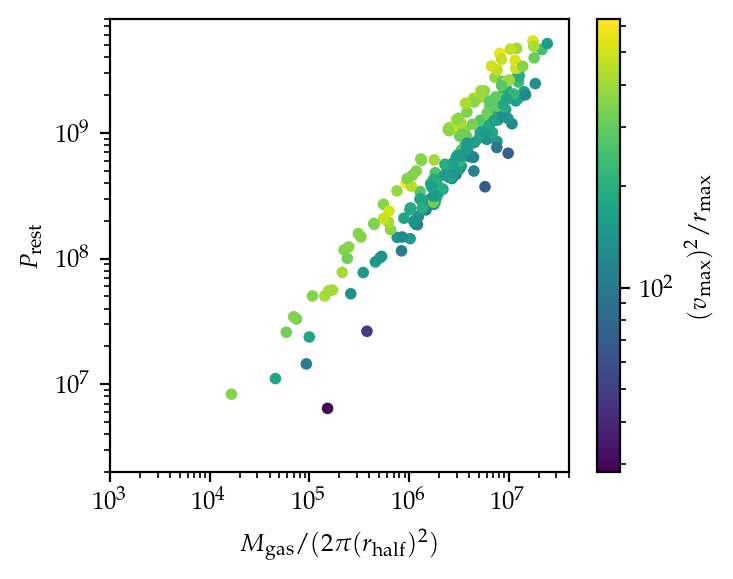

In [680]:
plt.figure(dpi=200, figsize=(3.7,3))
plt.scatter(data_all.SigmaGas, data_all.Prest, s=10, c=dphidz, norm=mpl.colors.LogNorm())
plt.colorbar(label=r'$(v_{\rm max})^2/r_{\rm max}$')
plt.loglog()
plt.ylim(2e6, 8e9)
plt.xlim(1e3, 4e7)
plt.xlabel(r'$M_{\rm gas}/(2\pi (r_{\rm half})^2)$')
plt.ylabel(r'$P_{\rm rest}$')
plt.show()

In [681]:
from sklearn import linear_model
import statsmodels.api as sm

y = np.array(data_all.Prest,dtype=float)
x1 = np.array(dphidz,dtype=float)
x2 = np.array(data_all.SigmaGas,dtype=float)
criteria = (x1 != 0) & (x2 != 0) & (y != 0)
Stock_Market = {'Prest': np.log10(y[criteria]),
                'dphidz': np.log10(x1[criteria]),
                'SigmaGas': np.log10(x2[criteria])
                }

df = pd.DataFrame(Stock_Market,columns=['Prest', 'dphidz', 'SigmaGas'])

X = df[['SigmaGas']] 
Y = df['Prest']
regr = linear_model.LinearRegression()
regr.fit(X, Y)
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)


X = df[['dphidz']] 
Y = df['Prest']
regr = linear_model.LinearRegression()
regr.fit(X, Y)
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  Prest   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     2332.
Date:                Tue, 20 Apr 2021   Prob (F-statistic):          5.05e-116
Time:                        19:17:54   Log-Likelihood:                 65.498
No. Observations:                 213   AIC:                            -127.0
Df Residuals:                     211   BIC:                            -120.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8922      0.122     23.738      0.0

## Interpretation of this result

Based on a simple OLS regression model between $\log_{10}(\Sigma_{\rm gas})$ and $\log_{10}(P_{\rm rest})$, $\sim$ 91% of the variation in $P_{\rm rest}$ can be accounted for by the variation in $\Sigma_{\rm gas}$. 

Tidal effects can certainly lead to variation in $\Sigma_{\rm gas}$ by spreading out the gas distribution. However, ram pressure stripping will also affect $\Sigma_{\rm gas}$ so this does not serve as a particularly valuable test. However, tidal effects will essentially be the only thing leading to variation in $d\Phi/dz$, so the fact that this variable seems to unrelated to $P_{\rm rest}$ suggests that tidal effects do not serve to reduce $P_{\rm rest}$ significantly. 

In [562]:
class MidPointLogNorm(mpl.colors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mpl.colors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

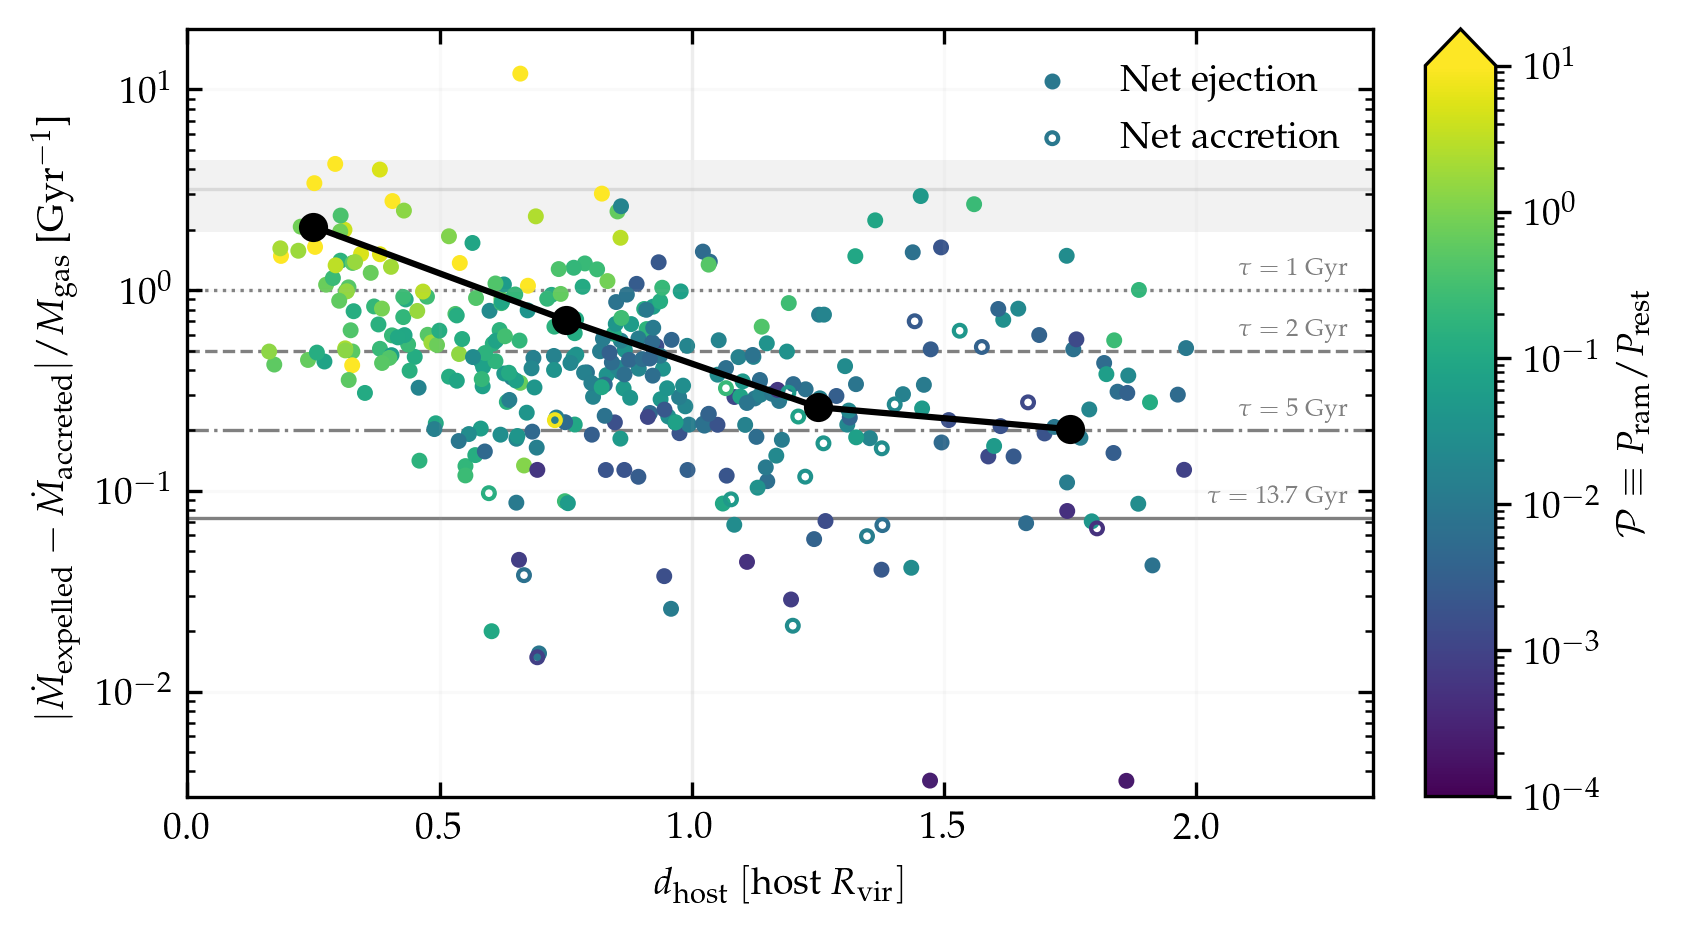

In [623]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(5.5, 3), constrained_layout=True)

c = data_all.ratio
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
x = data_all.h1dist/data_all.hostRvir
norm = mpl.colors.LogNorm(vmin=1e-4, vmax=1e1)

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, fc='none')
fig.colorbar(im, ax=ax, label=r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$', extend='max')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.semilogy()
ax.set_xlim(0,2.35)
ax.set_ylim(3e-3, 2e1)
ax.legend(frameon=False, loc='upper right')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([0,4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([0,4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([0,4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([0,4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (2.3, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2.3, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2.3, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2.3, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([0, 4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([0, 4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

bins = np.arange(0, 2.5, 0.5)
binned_netOutIn = np.array([])
for left_edge, right_edge in zip(bins[:-1],bins[1:]):
    cond = (x >= left_edge) & (x < right_edge)
    y = data_all.Mdot_expelled - data_all.Mdot_accreted
    ydiv = data_all.Mgas_div
    netOutIn = (np.sum(y[cond & (y >= 0)]) - np.sum(-y[cond & (y < 0)])) / np.sum(ydiv[cond])
    binned_netOutIn = np.append(binned_netOutIn, netOutIn)

bc = 0.5*(bins[1:]+bins[:-1])
ax.plot(bc, binned_netOutIn, 'ko-')




# plt.savefig('plots/net_Mdot.pdf')
plt.show()

In [612]:
data_all.keys()

Index(['t', 'a', 'h1dist', 'dNN', 'M_star', 'M_gas', 'satRvir', 'hostRvir',
       'vel_CGM', 'rho_CGM', 'Pram', 'n_CGM', 'vel_CGM_adv', 'rho_CGM_adv',
       'std_vel_CGM', 'std_rho_CGM', 'Pram_adv', 'Prest', 'SigmaGas', 'dphidz',
       'SFR', 'sSFR', 'ratio', 'dt', 'tau', 'tquench', 'time_x', 'M_disk',
       'time_y', 'M_ejected', 'Mdot_ejected', 'Mdot_ejected_by_Mgas',
       'Mdot_ejected_by_Mdisk', 'time_x', 'M_cooled', 'Mdot_cooled',
       'Mdot_cooled_by_Mgas', 'Mdot_cooled_by_Mdisk', 'time_y', 'M_expelled',
       'Mdot_expelled', 'Mdot_expelled_by_Mgas', 'time_x', 'M_expelled_disk',
       'Mdot_expelled_disk', 'Mdot_expelled_disk_by_Mgas',
       'Mdot_expelled_disk_by_Mdisk', 'time_y', 'M_expelled_th30',
       'Mdot_expelled_th30', 'Mdot_expelled_th30_by_Mgas', 'time_x',
       'M_accreted', 'Mdot_accreted', 'Mdot_accreted_by_Mgas', 'time_y',
       'M_accreted_disk', 'Mdot_accreted_disk', 'Mdot_accreted_disk_by_Mgas',
       'Mdot_gas', 'Mdot_disk', 'key', 'f_gas'],
   

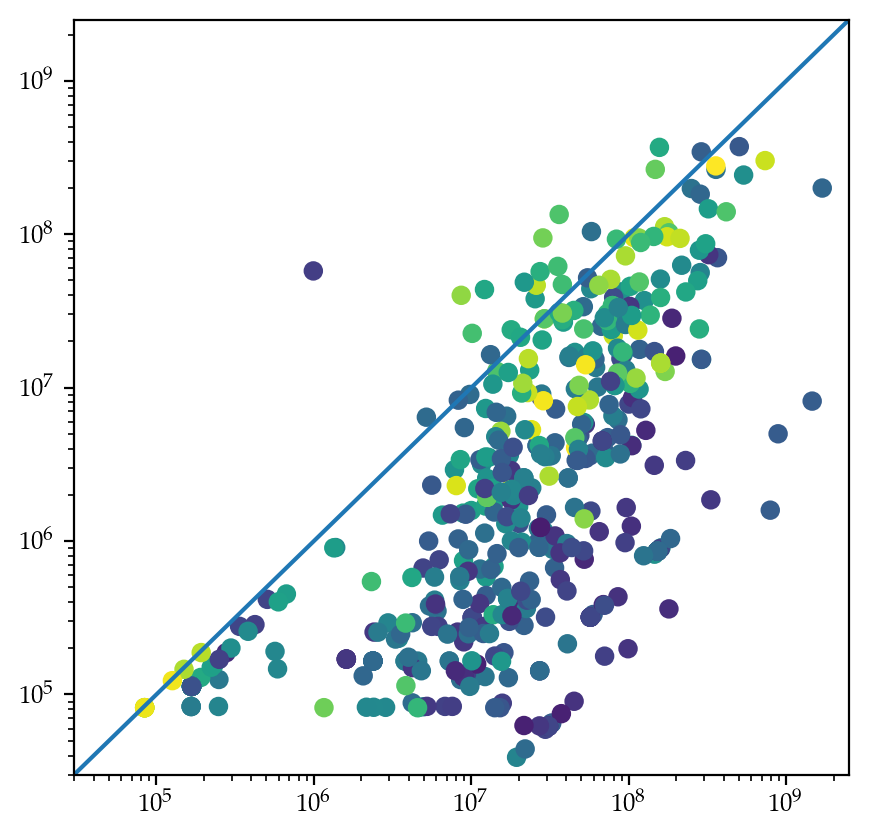

In [28]:
fig, ax = plt.subplots(1,1,dpi=200,figsize=(5,5))

ax.scatter(data_all.Mdot_expelled, data_all.Mdot_accreted, c=data_all.h1dist/data_all.hostRvir, norm=mpl.colors.Normalize(vmin=0, vmax=2))

ax.axline((1e4,1e4),(1e10,1e10))
ax.set_xlim(3e4, 2.5e9)
ax.set_ylim(3e4, 2.5e9)
ax.loglog()
plt.show()

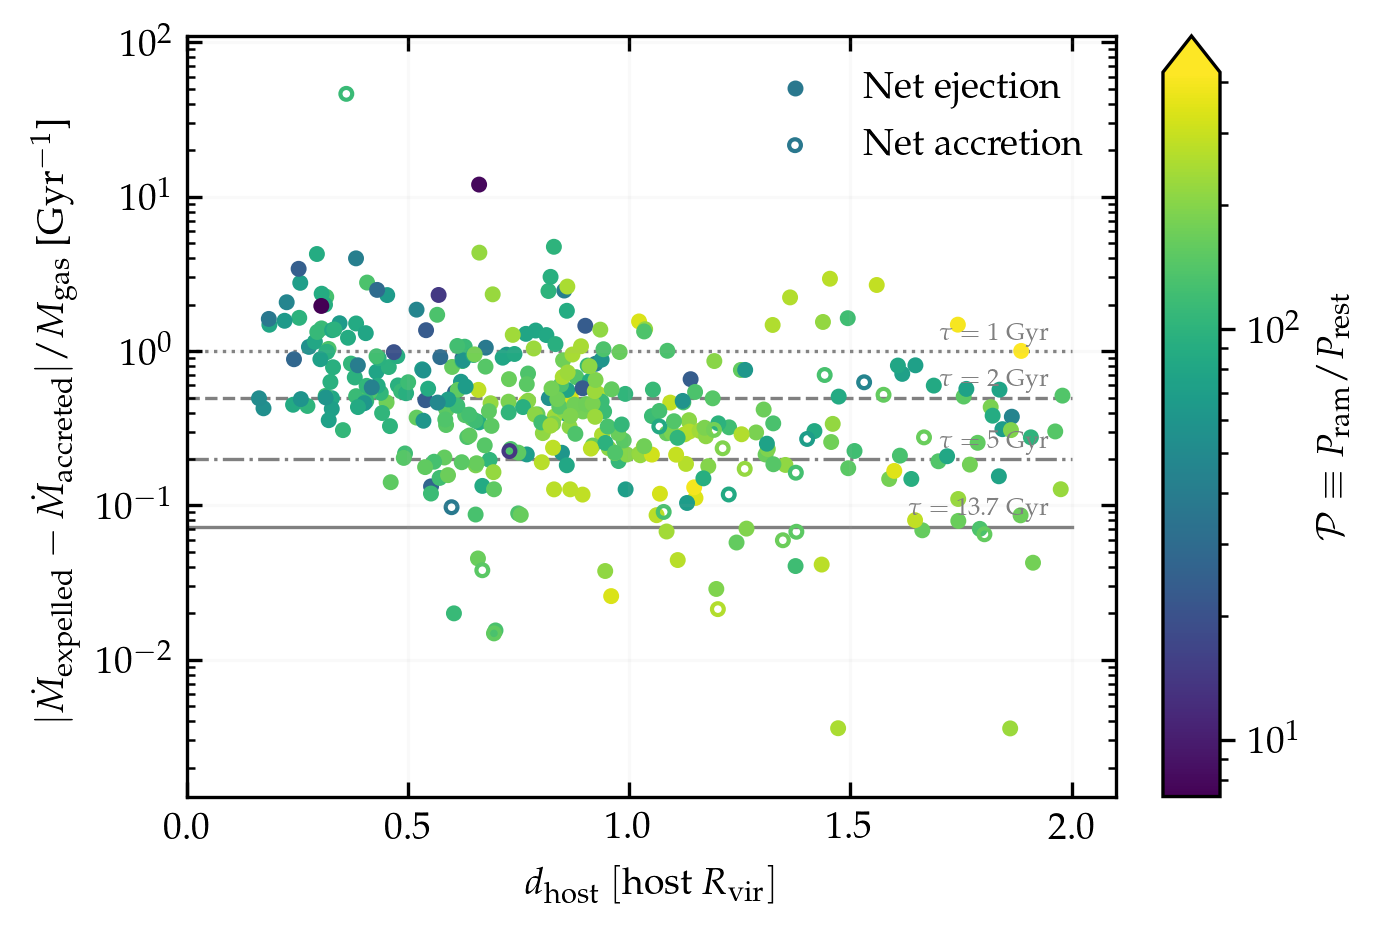

In [605]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 3), constrained_layout=True)

c = data_all.dNN
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
x = data_all.h1dist/data_all.hostRvir
norm = mpl.colors.LogNorm()

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, fc='none')
fig.colorbar(im, ax=ax, label=r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$', extend='max')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.semilogy()
ax.set_xlim(0,2.1)
ax.set_ylim(1.3e-3, 1.1e2)
ax.legend(frameon=False, loc='upper right')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([0,2], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([0,2], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([0,2], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([0,2], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (1.95, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (1.95, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (1.95, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (1.95, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

plt.show()

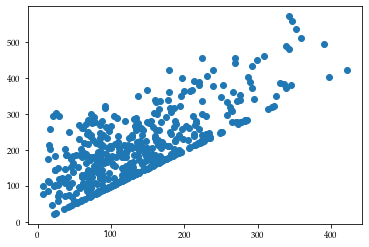

In [570]:
plt.scatter(data_all.dNN, data_all.h1dist)

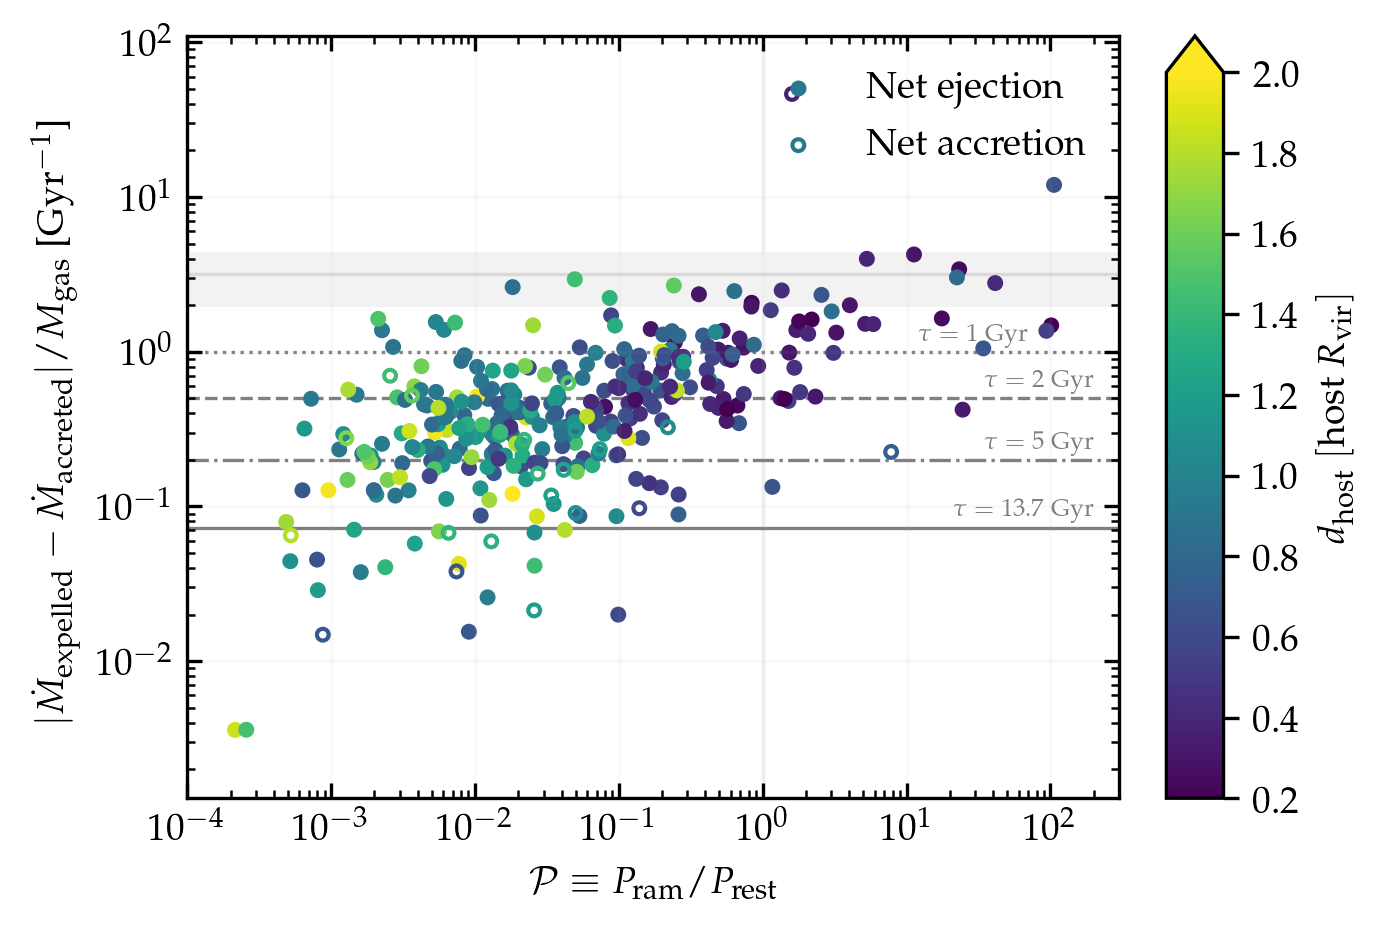

In [29]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 3), constrained_layout=True)

x = data_all.ratio
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
c = data_all.h1dist/data_all.hostRvir
norm = mpl.colors.Normalize(vmin=0.2, vmax=2)

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, fc='none')
fig.colorbar(im, ax=ax, label=r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$', extend='max')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.loglog()
ax.set_xlim(1e-4,3e2)
ax.set_ylim(1.3e-3, 1.1e2)
ax.legend(frameon=False, loc='upper right')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([1e-4,1e4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (7e1, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2e2, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2e2, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2e2, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')
    
mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([1e-4,1e4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([1e-4,1e4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

plt.show()

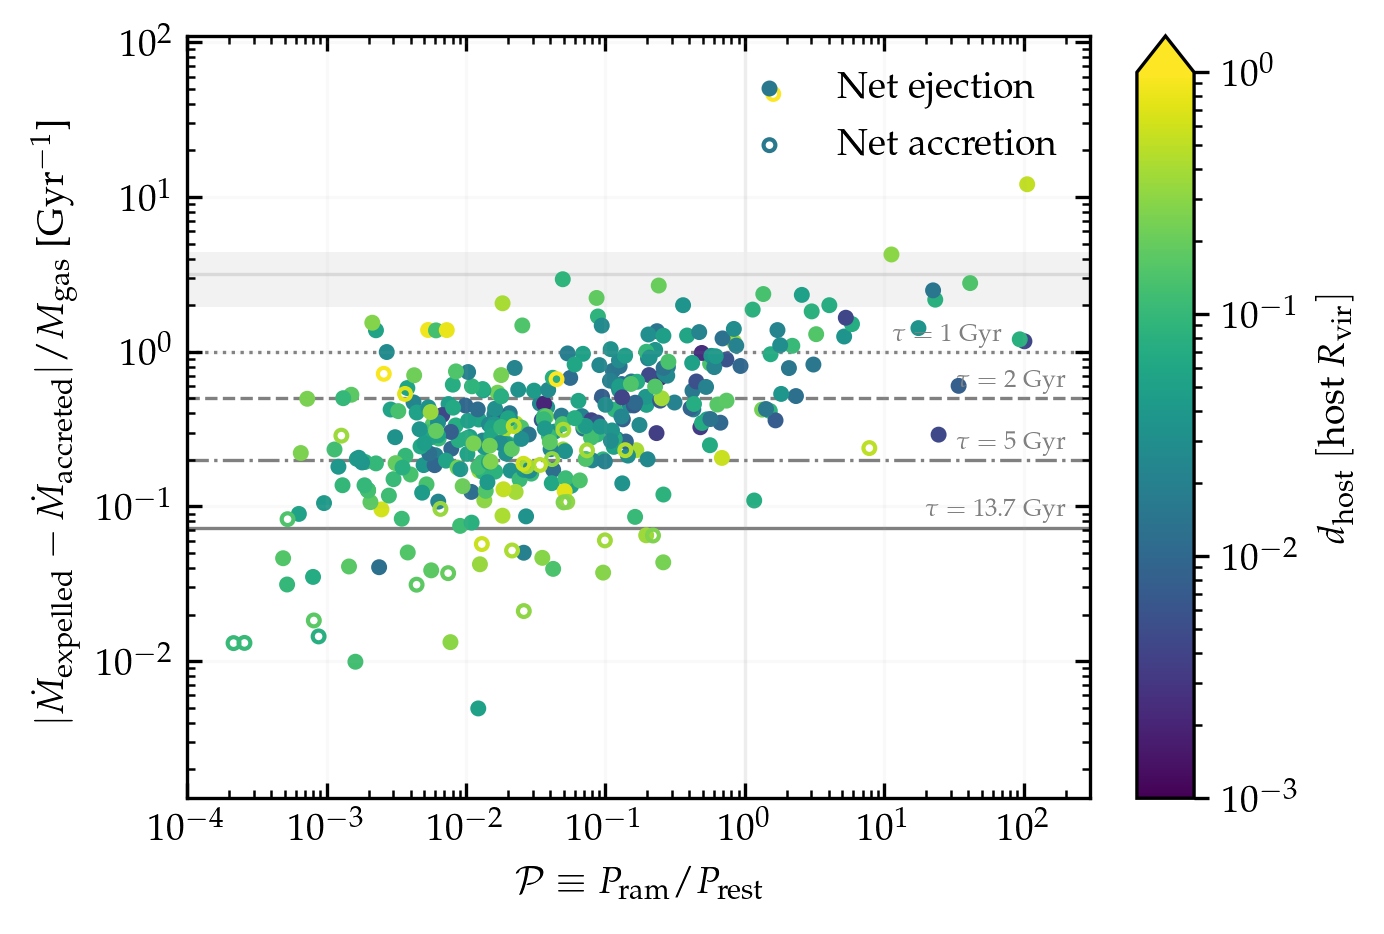

In [640]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 3), constrained_layout=True)

x = data_all.ratio
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
c = data_all.Mdot_accreted_by_Mgas
norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1e0)

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, fc='none')
fig.colorbar(im, ax=ax, label=r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$', extend='max')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.loglog()
ax.set_xlim(1e-4,3e2)
ax.set_ylim(1.3e-3, 1.1e2)
ax.legend(frameon=False, loc='upper right')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([1e-4,1e4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (7e1, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2e2, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2e2, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2e2, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')
    
mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([1e-4,1e4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([1e-4,1e4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

plt.show()

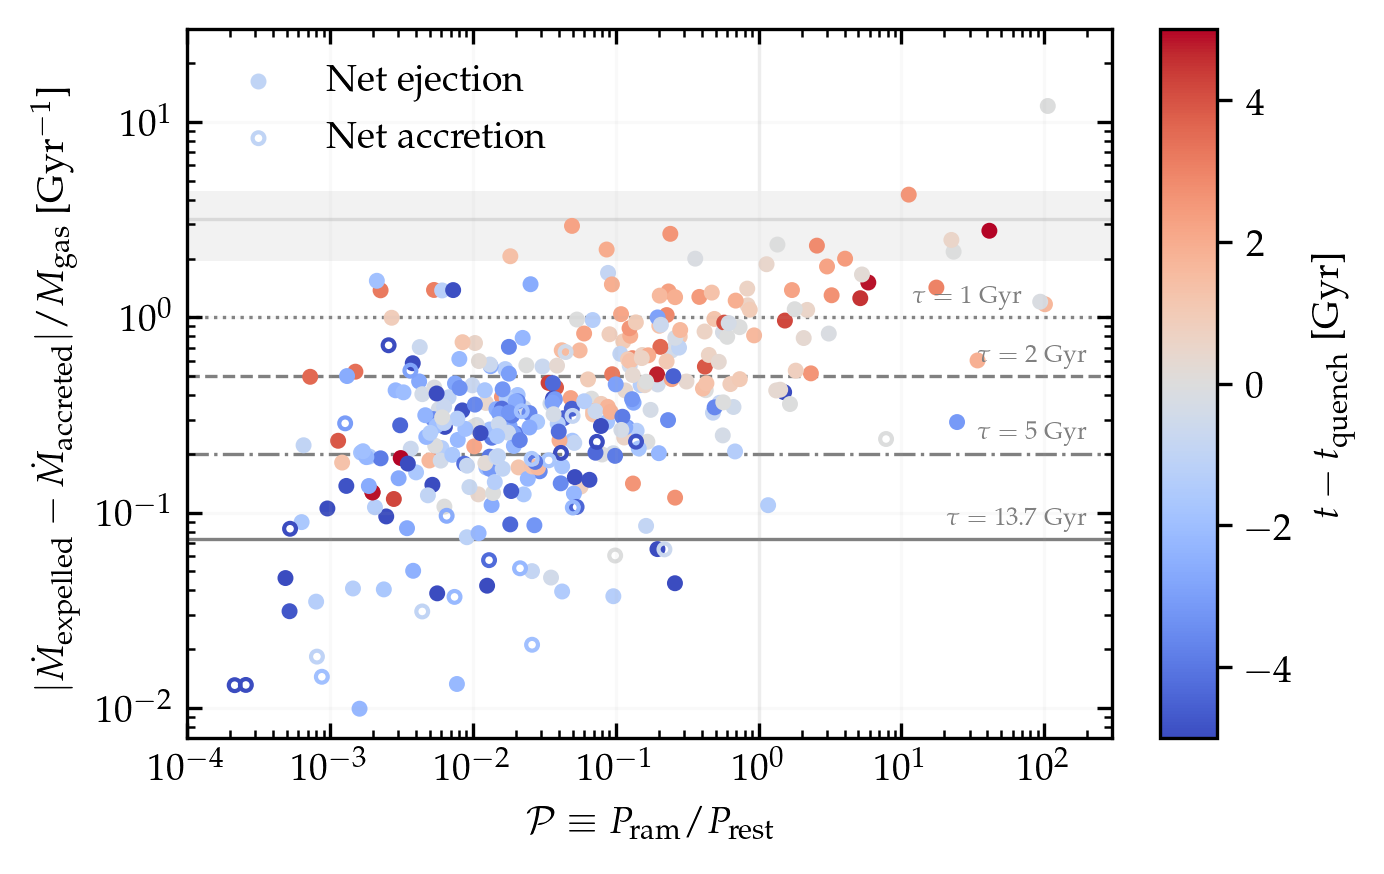

In [722]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 2.8), constrained_layout=True)

x = data_all.ratio
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
c = data_all.t-data_all.tquench
norm = mpl.colors.Normalize(vmin=-5, vmax=5)
cmap_name = 'coolwarm'

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm, cmap=cmap_name)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, fc='none', cmap=cmap_name)
fig.colorbar(im, ax=ax, label=r'$t-t_{\rm quench}$ [Gyr]')

cmap = mpl.cm.get_cmap(cmap_name)
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.loglog()
ax.set_xlim(1e-4,3e2)
ax.set_ylim(7e-3, 3e1)
ax.legend(frameon=False, loc='upper left')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([1e-4,1e4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (7e1, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2e2, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2e2, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2e2, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')
    
mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([1e-4,1e4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([1e-4,1e4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

plt.show()

In [728]:
plt.scatter(np.log10(x), np.log10(y), c=range(len(x)), zorder=np.array(range(len(x))))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 432x288 with 1 Axes>

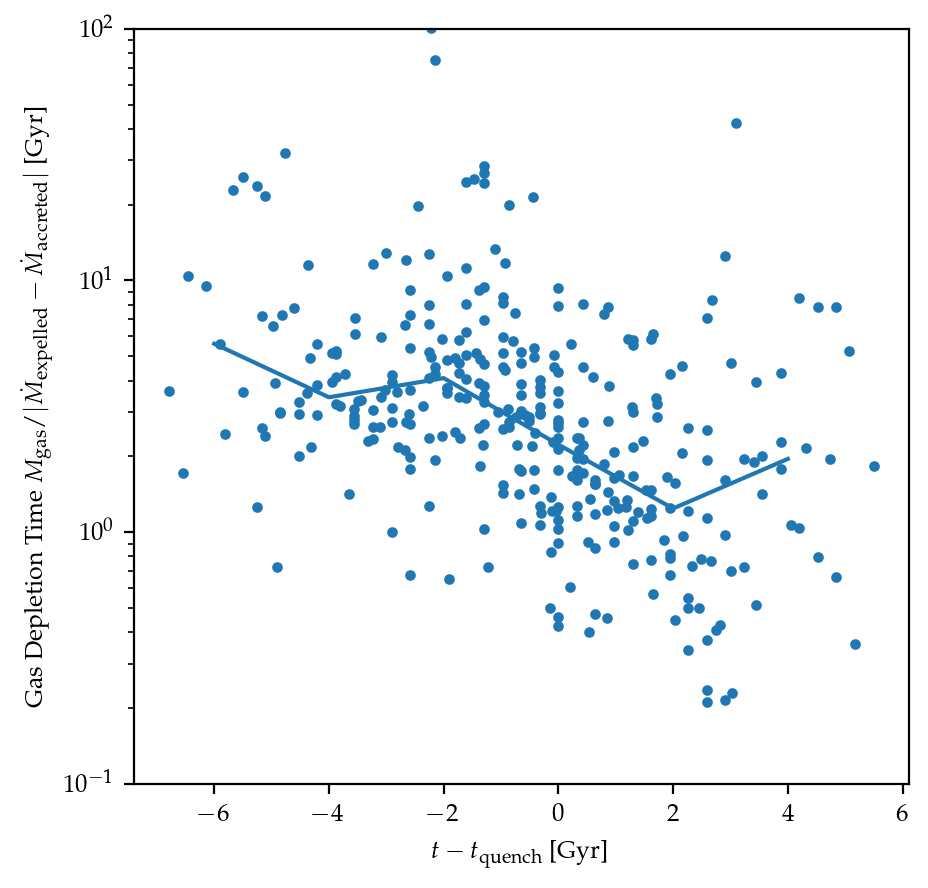

In [224]:
plt.figure(dpi=200, figsize=(5,5))
plt.scatter(c, 1/y, s=8)
plt.semilogy()
plt.ylim(1e-1, 1e2)
plt.ylabel(r'Gas Depletion Time $M_{\rm gas}/|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|$ [Gyr]')
plt.xlabel(r'$t-t_{\rm quench}$ [Gyr]')

import scipy.stats
mean, bins, binnumber = scipy.stats.binned_statistic(c[y>=0], 1/y[y>=0], statistic='median', bins=np.arange(-7, 7, 2))
bincenters = 0.5*(bins[1:]+bins[:-1])
plt.plot(bincenters, mean)

plt.show()


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


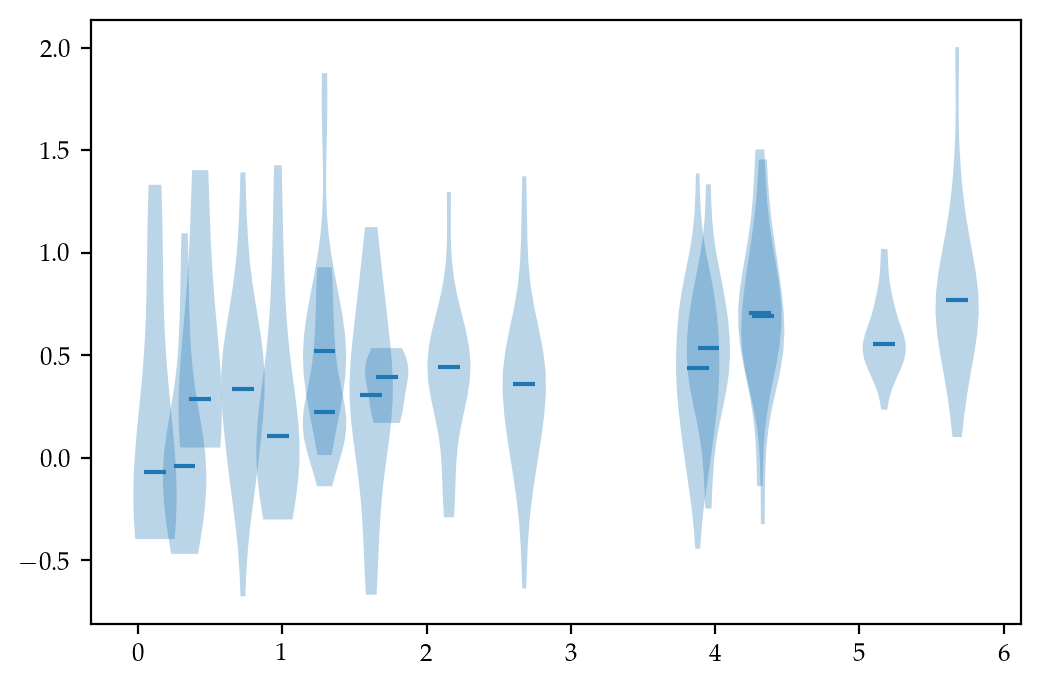

In [164]:
import weighted
from matplotlib.cbook import violin_stats
from scipy import stats
import statsmodels.api as sm

def vdensity_with_weights(weights):
    ''' Outer function allows innder function access to weights. Matplotlib
    needs function to take in data and coords, so this seems like only way
    to 'pass' custom density function a set of weights '''
    
    def vdensity(data, coords):
        ''' Custom matplotlib weighted violin stats function '''
        # Using weights from closure, get KDE fomr statsmodels
        weighted_cost = sm.nonparametric.KDEUnivariate(data)
        weighted_cost.fit(fft=False, weights=weights)

        # Return y-values for graph of KDE by evaluating on coords
        return weighted_cost.evaluate(coords)
    return vdensity

def custom_violin_stats(data, weights):
    # Get weighted median and mean (using weighted module for median)
    median = weighted.quantile_1D(data, weights, 0.5)
    mean, sumw = np.ma.average(data, weights=list(weights), returned=True)
    
    # Use matplotlib violin_stats, which expects a function that takes in data and coords
    # which we get from closure above
    results = violin_stats(data, vdensity_with_weights(weights))
    
    # Update result dictionary with our updated info
    results[0][u"mean"] = mean
    results[0][u"median"] = median
    
    # No need to do this, since it should be populated from violin_stats
    # results[0][u"min"] =  np.min(data)
    # results[0][u"max"] =  np.max(data)

    return results

### Example
#vpstats1 = custom_violin_stats(np.asarray(df_column_data), np.asarray(df_column_weights))
#vplot = ax.violin(vpstats1, [pos_idx], vert=False, showmeans=True, showextrema=True, showmedians=True)
#current_color_palette = ...
#for pc in vplot['bodies']:
#    pc.set_facecolor(current_color_palette[pos_idx])
#    pc.set_edgecolor('black')


plt.figure(dpi=200)


fs = 10  # fontsize
pos = [data_all[data_all.key==key].tau.mean() for key in np.unique(data_all.key)]
data = [np.log10(np.array(1/y,dtype=float))[data_all.key==key] for key in np.unique(data_all.key)]
# weights = [np(np.array(1/y,dtype=float))[data_all.key==key] for key in np.unique(data_all.key)]
data = [d[~np.isnan(d)] for d in data]
data = [d[~np.isinf(d)] for d in data]


vpstats1 = custom_violin_stats(np.asarray(data), np.asarray(weights))

plt.violinplot(data, pos, points=20, widths=0.3,
               showmedians=True, showextrema=False)


# plt.scatter(pos, 10**np.array([np.median(d) for d in data]))
# plt.scatter(data_all.tau, np.log10(np.array(1/y,dtype=float)), alpha=0.5)
plt.show()

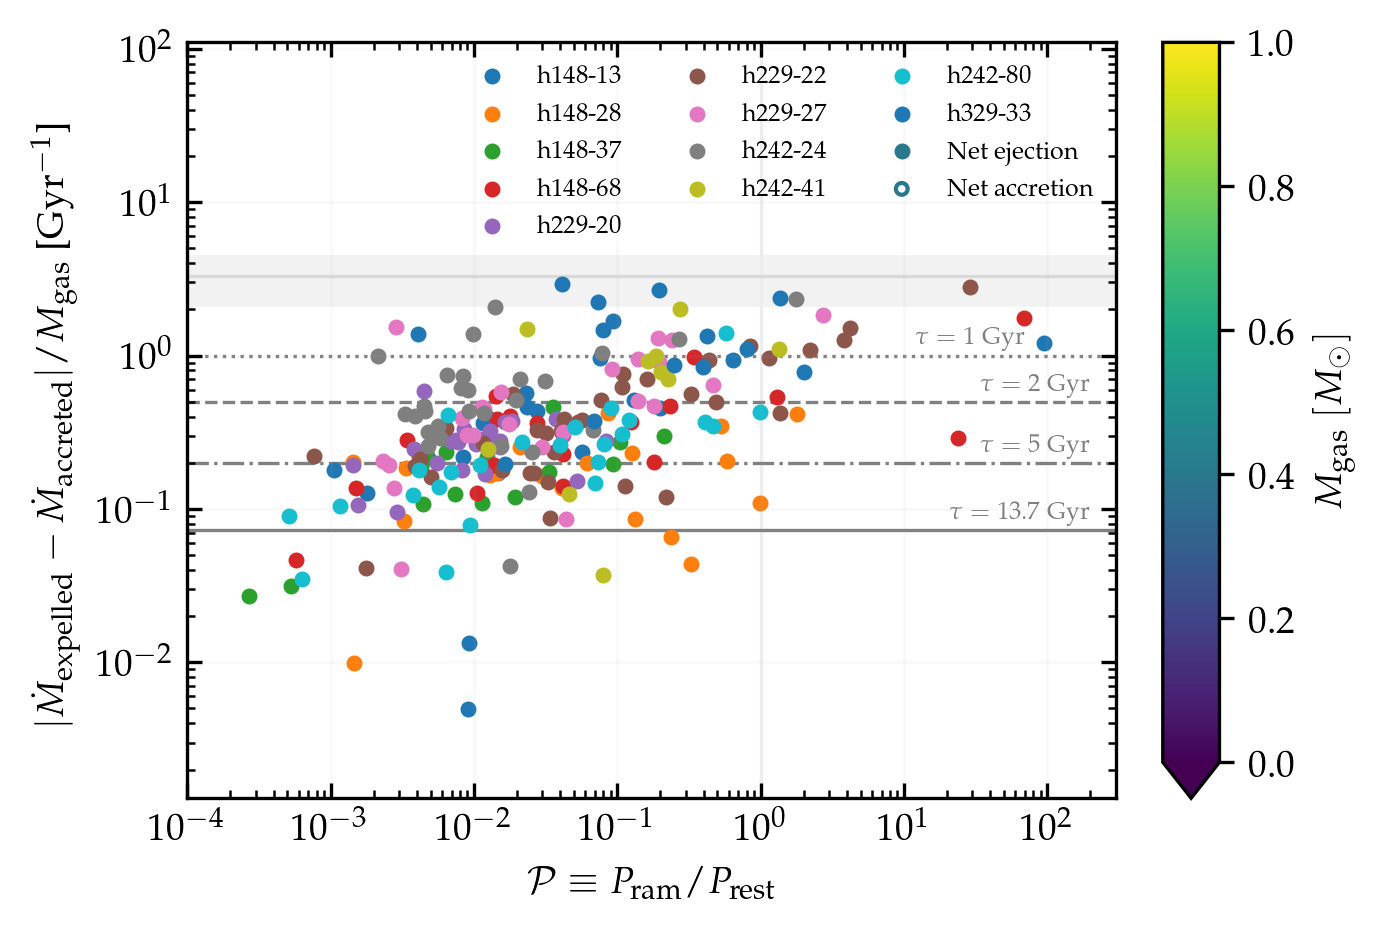

In [106]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 3), constrained_layout=True)

norm = mpl.colors.LogNorm(1e-4,7e-1)

for key in np.unique(data_all.key):
    d = data_all[data_all.key==key]
    x = d.ratio
    y = d.Mdot_expelled_by_Mgas - d.Mdot_accreted_by_Mgas
    im = ax.scatter(x[y >= 0], y[y >= 0], s=8, label=key.replace('_','-'))
    #im = ax.scatter(x[y < 0], -y[y < 0], s=8)

fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}~[M_{\odot}]$',extend='min')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.loglog()
ax.set_xlim(1e-4,3e2)
ax.set_ylim(1.3e-3, 1.1e2)
ax.legend(frameon=False, fontsize=6, ncol=3)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([1e-4,1e4], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([1e-4,1e4], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (7e1, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (2e2, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (2e2, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (2e2, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')
    
mu = 1/np.mean(data_all.dt)
sigma = np.std(data_all.dt)/(np.mean(data_all.dt)**2)
ax.plot([1e-4,1e4],[mu]*2,color='0.85', linestyle='-', linewidth=0.8, zorder=-100)
ax.fill_between([1e-4,1e4],[mu-sigma]*2,[mu+sigma]*2, fc='0.95', zorder=-110)
ax.plot([1,1],[1e-3,1e3],color='0.95', linestyle='-', linewidth=0.8, zorder=-1000)

plt.show()

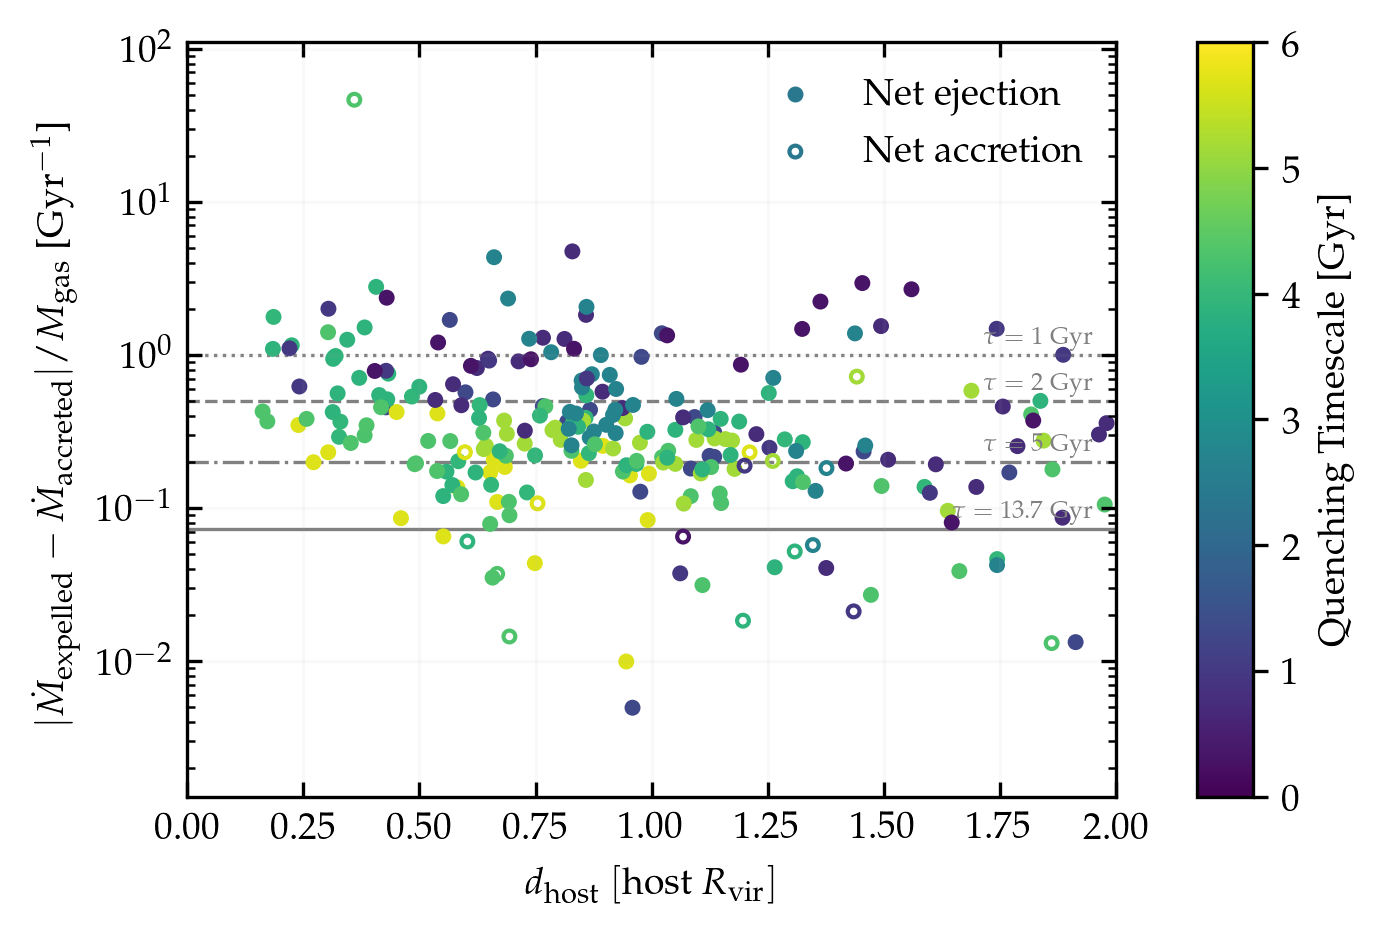

In [82]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 3), constrained_layout=True)

c = data_all.tau
y = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
x = data_all.h1dist/data_all.hostRvir
norm = mpl.colors.Normalize(vmin=0, vmax=6)

im = ax.scatter(x[y >= 0], y[y >= 0], c=c[y >= 0], s=8, norm=norm)
im = ax.scatter(x[y < 0], -y[y < 0], c=c[y < 0], s=8, norm=norm, fc='none')
fig.colorbar(im, ax=ax, label=r'Quenching Timescale [Gyr]')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.semilogy()
ax.set_xlim(0,2)
ax.set_ylim(1.3e-3, 1.1e2)
ax.legend(frameon=False, loc='upper right')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
ax.plot([0,2], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
ax.plot([0,2], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
ax.plot([0,2], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
ax.plot([0,2], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
ax.annotate(r'$\tau = 1~{\rm Gyr}$', (1.95, 1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 2~{\rm Gyr}$', (1.95, 0.5*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 5~{\rm Gyr}$', (1.95, 0.2*1.2), color='0.5', fontsize=6, ha='right')
ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (1.95, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

plt.show()

(array([3., 3., 4., 6., 2., 0., 0., 0., 1., 1.]),
 array([-0.3317141 , -0.07419779,  0.18331851,  0.44083482,  0.69835113,
         0.95586743,  1.21338374,  1.47090005,  1.72841635,  1.98593266,
         2.24344897]),
 <BarContainer object of 10 artists>)

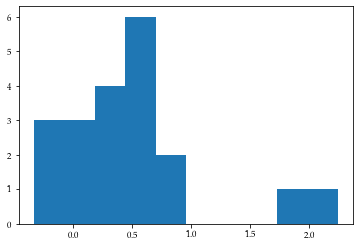

In [736]:
plt.hist(data[0])

In [723]:
data

[array([        nan,  1.86867004,  0.75770417,  0.59641645, -0.22810269,
        -0.3317141 ,  0.1829263 ,  0.05083239,  0.33288325,  0.85572581,
         0.68394035,  0.59182809,  0.50571827,  0.60225621,  0.30960305,
         0.62406641, -0.14494093,  2.24344897,  0.25373614,  0.23910156,
         0.17179175]),
 array([       nan,        nan,        nan, 1.33438877, 0.98303045,
        0.35325032,        nan,        nan, 0.50775418, 0.74285174,
        0.73060398, 1.05432027, 1.99633492, 0.64879566, 0.93557136,
        0.6835969 , 1.03864481, 0.36319054, 0.60757883, 0.58807549,
        0.29591441, 0.82669623, 0.73269149, 0.69963717]),
 array([       nan,        nan, 1.56093899, 1.49625839, 0.23087689,
        0.665886  , 0.41629931, 0.48687837, 0.61408728, 0.95945235,
        0.58066946, 0.70488085, 0.62653684, 0.61628385, 0.90245984,
        0.69691893, 0.94712697, 0.88079101]),
 array([        nan,         nan,         nan,  1.32984334,  0.84312886,
         0.49252143,  0.66959888

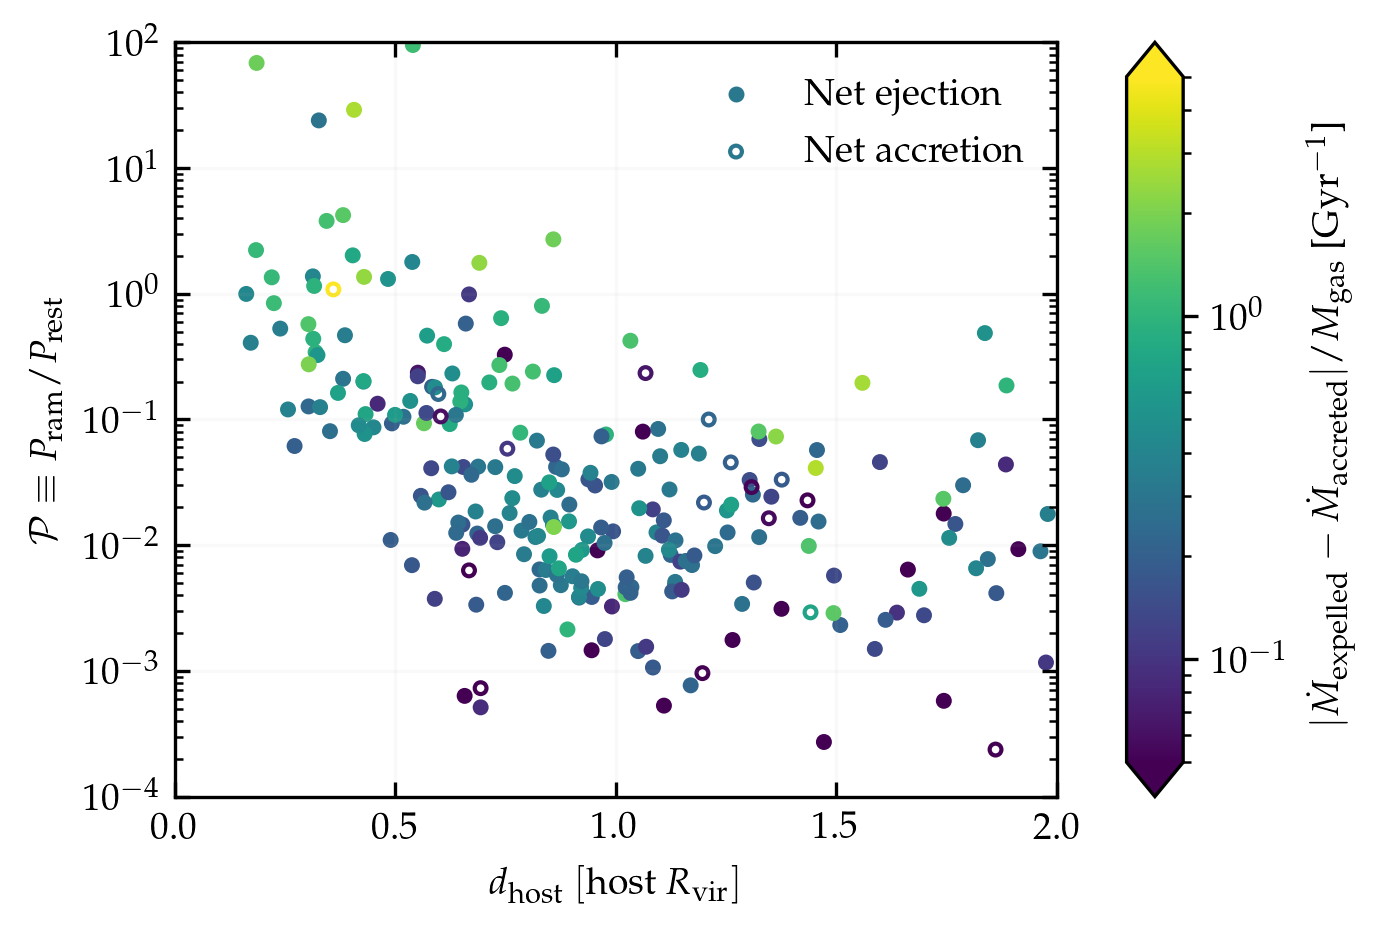

In [65]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 3), constrained_layout=True)

y = data_all.ratio
c = data_all.Mdot_expelled_by_Mgas - data_all.Mdot_accreted_by_Mgas
x = data_all.h1dist/data_all.hostRvir
norm = mpl.colors.LogNorm(vmin=5e-2, vmax=5)

im = ax.scatter(x[c >= 0], y[c >= 0], c=c[c >= 0], s=8, norm=norm)
im = ax.scatter(x[c < 0], y[c < 0], c=-c[c < 0], s=8, norm=norm, fc='none')
fig.colorbar(im, ax=ax, label=r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]', extend='both')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')
ax.set_ylabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.semilogy()
ax.set_xlim(0,2)
ax.set_ylim(1e-4, 1e2)
ax.legend(frameon=False, loc='upper right')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
# ax.plot([0,2], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
# ax.plot([0,2], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
# ax.plot([0,2], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
# ax.plot([0,2], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
# ax.annotate(r'$\tau = 1~{\rm Gyr}$', (1.95, 1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 2~{\rm Gyr}$', (1.95, 0.5*1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 5~{\rm Gyr}$', (1.95, 0.2*1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (1.95, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

plt.show()

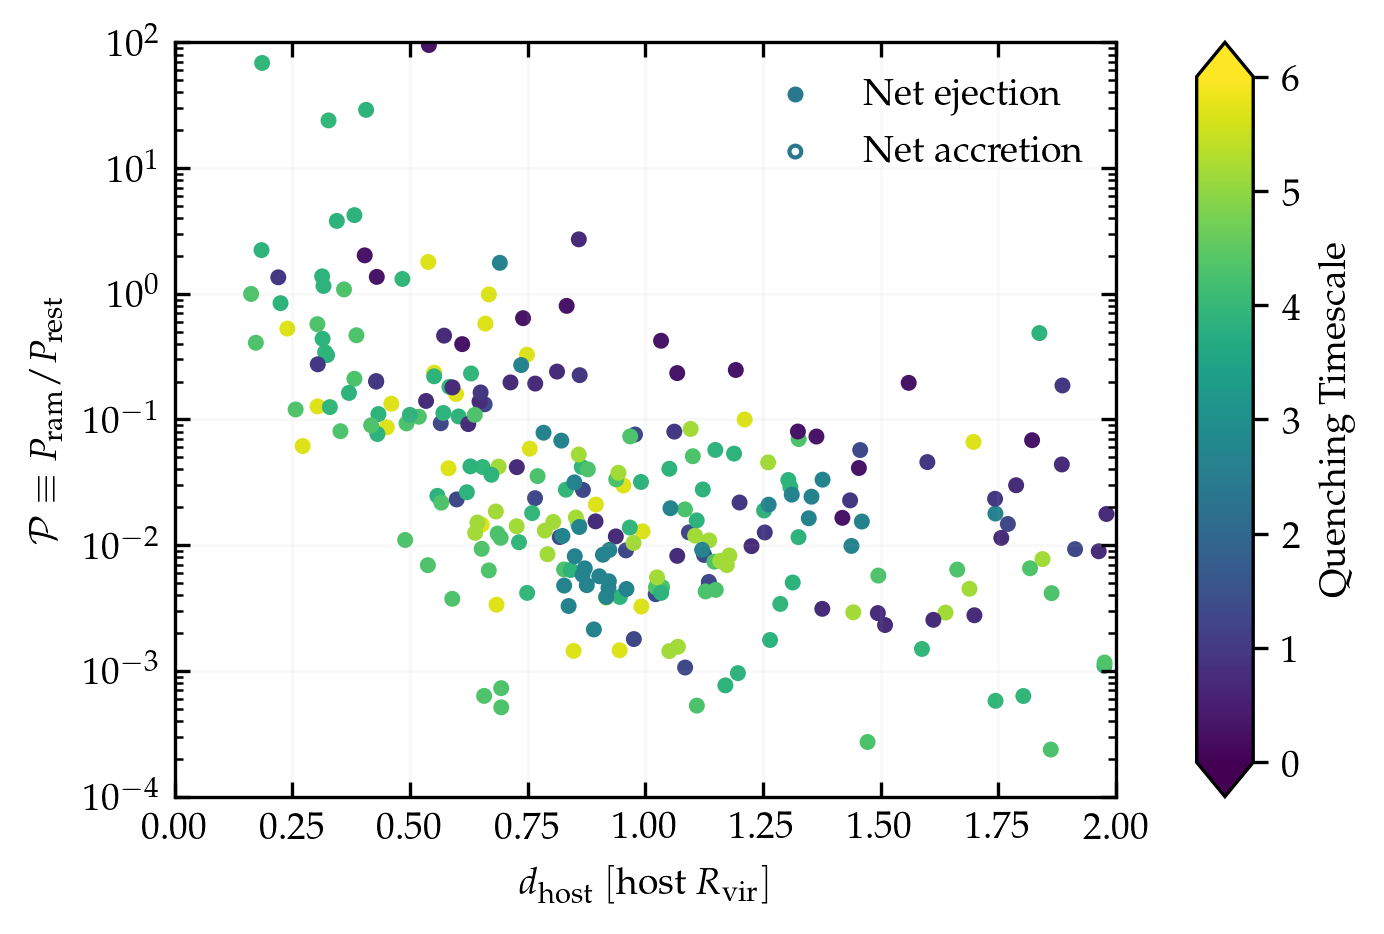

In [77]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 3), constrained_layout=True)

y = data_all.ratio
c = data_all.tau
x = data_all.h1dist/data_all.hostRvir
norm = mpl.colors.Normalize(vmin=0, vmax=6)

im = ax.scatter(x[c >= 0], y[c >= 0], c=c[c >= 0], s=8, norm=norm)
im = ax.scatter(x[c < 0], y[c < 0], c=-c[c < 0], s=8, norm=norm, fc='none')
fig.colorbar(im, ax=ax, label=r'Quenching Timescale', extend='both')

cmap = mpl.cm.get_cmap('viridis')
ax.scatter([1e6],[1e6], s=8, fc=cmap(0.4), ec=cmap(0.4), label='Net ejection')
ax.scatter([1e6],[1e6], s=8, fc='none', ec=cmap(0.4), label='Net accretion')

ax.set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')
ax.set_ylabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$')
# ax.set_yscale('symlog', linthresh = 1e5, linscale=0.5)
ax.semilogy()
ax.set_xlim(0,2)
ax.set_ylim(1e-4, 1e2)
ax.legend(frameon=False, loc='upper right')
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
# ax.plot([0,2], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
# ax.plot([0,2], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
# ax.plot([0,2], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
# ax.plot([0,2], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
# ax.annotate(r'$\tau = 1~{\rm Gyr}$', (1.95, 1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 2~{\rm Gyr}$', (1.95, 0.5*1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 5~{\rm Gyr}$', (1.95, 0.2*1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (1.95, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

plt.show()

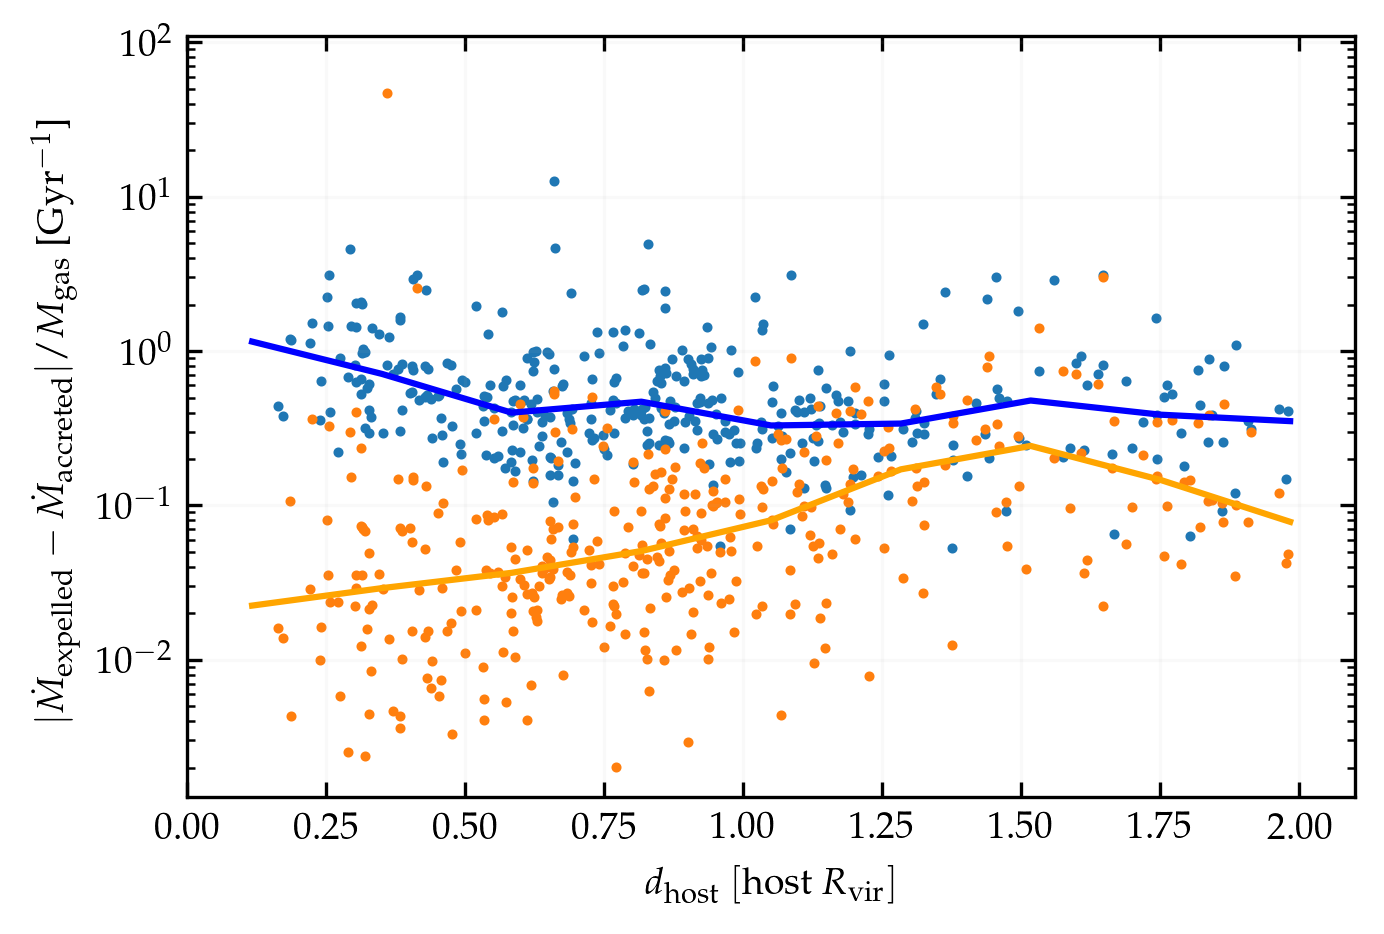

In [584]:
import scipy.stats
bins = np.linspace(0, 2.1, 10)

fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5, 3), constrained_layout=True)

y1 = np.array(data_all.Mdot_expelled_by_Mgas,dtype=float)
y2 = np.array(data_all.Mdot_accreted_by_Mgas,dtype=float)
x = data_all.h1dist/data_all.hostRvir


ax.scatter(x, y1, s=2)

c = ~np.isinf(y1) & ~np.isnan(y1) & (y1 > 0)
median, bins, binnumber = scipy.stats.binned_statistic(x[c], y1[c], statistic='median', bins=bins)
# std, bins, binnumber = scipy.stats.binned_statistic(x[c], y1[c], statistic='std', bins=bins)
bincenters = 0.5*(bins[1:]+bins[:-1])
ax.plot(bincenters, median, color='b')
# ax.fill_between(bincenters, median-std, median+std, ec='none', fc='b', alpha=0.2)



ax.scatter(x, y2, s=2)

c = ~np.isinf(y2) & ~np.isnan(y2) & (y2 > 0)
median, bins, binnumber = scipy.stats.binned_statistic(x[c], y2[c], statistic='median', bins=bins)
# std, bins, binnumber = scipy.stats.binned_statistic(x[c], y1[c], statistic='std', bins=bins)
bincenters = 0.5*(bins[1:]+bins[:-1])
ax.plot(bincenters, median, color='orange')
# ax.fill_between(bincenters, median-std, median+std, ec='none', fc='b', alpha=0.2)







ax.set_xlabel(r'$d_{\rm host}~[{\rm host}~R_{\rm vir}]$')
ax.set_ylabel(r'$|\dot{M}_{\rm expelled} - \dot{M}_{\rm accreted}|/M_{\rm gas}$ [Gyr$^{-1}$]')

ax.semilogy()
ax.set_xlim(0, 2.1)
ax.set_ylim(1.3e-3, 1.1e2)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.07, zorder=-1000)
# ax.plot([1e-5,1e2], [1, 1], linewidth=0.8, linestyle=':', color='0.5', zorder=-300)
# ax.plot([1e-5,1e2], [0.5, 0.5], linewidth=0.8, linestyle='--', color='0.5', zorder=-300)
# ax.plot([1e-5,1e2], [0.2, 0.2], linewidth=0.8, linestyle='-.', color='0.5', zorder=-300)
# ax.plot([1e-5,1e2], [1/13.7, 1/13.7], linewidth=0.8, linestyle='-', color='0.5', zorder=-300)
# ax.annotate(r'$\tau = 1~{\rm Gyr}$', (1.95, 1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 2~{\rm Gyr}$', (1.95, 0.5*1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 5~{\rm Gyr}$', (1.95, 0.2*1.2), color='0.5', fontsize=6, ha='right')
# ax.annotate(r'$\tau = 13.7~{\rm Gyr}$', (1.95, 1/13.7*1.2), color='0.5', fontsize=6, ha='right')

plt.show()